# **Maestría en Inteligencia Artificial Aplicada**
## **Curso: Proyecto Integrador**
### Tecnológico de Monterrey
### Prof.: Dra. Grettel Barceló

## **Actividad Semana 4**

### **Ingeniería de Características**

##### Nombres y matrículas de los integrantes del equipo:
*   Omar Juárez Téllez - A01795499
*   Victoria Melgarejo Cabrera - A01795030
*   Julio Cesar Mestas - A01794827

---


#### **Objetivo de la Actividad:**

2.3 Crear nuevas características para mejorar el rendimiento de los modelos.

2.4 Mitigar el riesgo de características sesgadas y acelerar la convergencia de algunos algoritmos.


---

## **1. Importación de Librerías**

In [1]:
!pip install -q sentence-transformers transformers accelerate unidecode
!pip install -q regex
!pip -q install imbalanced-learn xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 8.3 MB/s eta 0:00:00


In [18]:
import io
import os
import gc
import math
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from scipy import stats
from pandas.tseries.offsets import MonthBegin
import re
from unidecode import unidecode
import unicodedata
from collections import defaultdict
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from pathlib import Path
from itertools import islice

from IPython.display import display
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 180)
pd.set_option("display.max_colwidth", 200)

# Configuración visual
plt.style.use("seaborn-v0_8")
sns.set_palette("Set2")

# Carpeta de salida
OUTPUT_DIR = "./eda_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

## **2. Carga de Datos**

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**2.1 Preparación del Entorno y Lectura del Dataset**

Para asegurar la comparabilidad temporal y la consistencia del análisis, el estudio se restringe al periodo comprendido entre el **5 de junio de 2024** y el **5 de mayo de 2025**. En consecuencia, se excluyen observaciones fuera de estas fechas y todos los conteos mensuales, estadísticas descriptivas y resultados de modelado se reportan únicamente para los meses de junio de 2024 a mayo de 2025.

In [20]:
# Ruta base donde están los archivos
base_path = "/content/drive/Othercomputers/Mi PC/Google Drive/Documentos/Tec de Monterrey/MNA/PROYECTO INTEGRADOR/SEMANA 4/Resultados/"

In [21]:
# Nombre del archivo
file_name = "Master_Table_con_Target.csv"

# Lectura del archivo CSV
df_mastertable = pd.read_csv(f"{base_path}/{file_name}")
#df_mastertable = pd.read_csv(file_name)

In [22]:
# Validamos la correcta carga de los dataset
rows, cols = df_mastertable.shape
print(f"Dimensiones: {rows:,} filas × {cols:,} columnas")
print("\nTipos de datos (por columna):")
print(df_mastertable.dtypes)
print("\nResumen de tipos (conteo por dtype):")
print(df_mastertable.dtypes.value_counts())
print("\nPrimeras 3 filas:")
display(df_mastertable.head(3))

Dimensiones: 2,859 filas × 163 columnas

Tipos de datos (por columna):
Unnamed: 0.1              int64
Unnamed: 0                int64
ID_EHT                   object
FECHA_AFILIACION         object
FECHA_EGRESO             object
                         ...   
rx_antibioticos_w30d    float64
target_hosp_15d           int64
target_hosp_21d           int64
target_hosp_30d           int64
target_hosp_90d           int64
Length: 163, dtype: object

Resumen de tipos (conteo por dtype):
float64    145
object      10
int64        8
Name: count, dtype: int64

Primeras 3 filas:


,Unnamed: 0.1,Unnamed: 0,ID_EHT,FECHA_AFILIACION,FECHA_EGRESO,GENERO,FECHA_NACIMIENTO,UBICACION,START_MES_5,END_MES_5,FECHA_MES_5,CODMES,DIAS_EN_PROGRAMA,EDAD,pct_GRASA,ACIDO_URICO,ADE,ALBUMINA,ALBUMINA_EN_SUERO,AMILASA,ANTIGENO_PROSTATICO_ESPECIFICO,BASOFILOS,BASOFILOS_ABSOLUTOS,BILIRRUBINA_DIRECTA,BILIRRUBINA_INDIRECTA,BILIRRUBINA_TOTAL,BLASTOS,CA_125,CA_15-3,CADERA,CALCIO,CINTURA,CIRCUNFERENCIA_ABDOMINAL,CIRCUNFERENCIA_DE_CINTURA,COLESTEROL_HDL,COLESTEROL_LDL,COLESTEROL_TOTAL,COLESTEROL_VLDL,CONCENTRACION_DE_HEMOGLOBINA_CORPUSCULAR_MEDIA,CREATININA,CREATININA_SERICA,DENSIDAD,DESHIDROGENASA_LACTICA,EOSCINOFILOS,EOSINOFILOS_ABSOLUTOS,ERITROCITOS,FACTOR_REUMATOIDE_-,FERRITINA,FEV_1_FVC,FEVI,FOSFATA_ALCALINA,FOSFORO,FRECUENCIA_CARDIACA,FRECUENCIA_RESPIRATORIA,GAMAGLUTAMILTRANSPEPTIDASA_GGT,GLOBULINA,GLUCOSA_EN_ORINA,GLUCOSA_EN_SUERO_ALIMENTOS,GLUCOSA_EN_SUERO_AYUNO,HEMATOCRITOS,...,T4_LIBRE,TALLA,TEMPERATURA,TENSION_ARTERIAL_DIASTOLICA,TENSION_ARTERIAL_SISTOLICA,TESTOSTERONA,TGO,TGP,TIROXINA_T4,TRANSAMINASA_G_PIRUVICA_TGP,TRANSAMINASA_GLUTAMICO_OXALACETICA_TGO,TRIGLICERIDOS,TRIYODOTIRONINA_T3,TROPONINA_I_ULTRASENSIBLE,TSH,TUPTAKE_CAPTACION,UREA,VELOCIDAD_DE_SEDIMENTACION_GLOBULAR_<_50,VELOCIDAD_DE_SEDIMENTACION_GLOBULAR_>_50,VOLUMEN_CORPUSCULAR_MEDIO,VOLUMEN_GLOBULAR_MEDIO,VOLUMEN_PLAQUETARIO_MEDIO,YODO_PROTEICO,notas_w30d,tokens_notas_w30d,kw_adherencia_w30d,kw_infeccion_w30d,kw_dolor_w30d,kw_fiebre_w30d,kw_htn_w30d,kw_dm_w30d,dx_w30d,cie_cap_A_w30d,cie_cap_B_w30d,cie_cap_C_w30d,cie_cap_D_w30d,cie_cap_E_w30d,cie_cap_F_w30d,cie_cap_G_w30d,cie_cap_H_w30d,cie_cap_I_w30d,cie_cap_J_w30d,cie_cap_K_w30d,cie_cap_M_w30d,cie_cap_N_w30d,cie_cap_R_w30d,cie_cap_T_w30d,cie_cap_Z_w30d,rx_w30d,rx_meds_unicos_30d,rx_consultas_30d,rx_polifarmacia_30d,rx_antihipertensivos_w30d,rx_antidiabeticos_w30d,rx_estatinas_w30d,rx_antibioticos_w30d,target_hosp_15d,target_hosp_21d,target_hosp_30d,target_hosp_90d
0,0,0,Csalinas2265705,2024-06-05,2025-07-09,M,1967-07-08,Monterrey,2024-06-05,2025-07-09,2024-06-05,2024-06,0,56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
1,1,1,Csalinas2265705,2024-06-05,2025-07-09,M,1967-07-08,Monterrey,2024-06-05,2025-07-09,2024-07-05,2024-07,30,57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
2,2,2,Csalinas2265705,2024-06-05,2025-07-09,M,1967-07-08,Monterrey,2024-06-05,2025-07-09,2024-08-05,2024-08,61,57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0


**2.2 Inferencia de Tipos y Fechas (limpieza ligera)**

In [23]:
# --- Poblacion ---
df_mastertable["FECHA_AFILIACION"] = pd.to_datetime(
    df_mastertable["FECHA_AFILIACION"].astype(str).str.strip(),
    format="%Y-%m-%d", errors="coerce"
)
df_mastertable["FECHA_EGRESO"] = pd.to_datetime(
    df_mastertable["FECHA_EGRESO"].astype(str).str.strip(),
    format="%Y-%m-%d", errors="coerce"
)


In [24]:
df_mastertable_v1 = df_mastertable.iloc[:, 2:].copy().copy()
df_mastertable_v1[df_mastertable_v1['ID_EHT'] == 'vpoot2336437']

,ID_EHT,FECHA_AFILIACION,FECHA_EGRESO,GENERO,FECHA_NACIMIENTO,UBICACION,START_MES_5,END_MES_5,FECHA_MES_5,CODMES,DIAS_EN_PROGRAMA,EDAD,pct_GRASA,ACIDO_URICO,ADE,ALBUMINA,ALBUMINA_EN_SUERO,AMILASA,ANTIGENO_PROSTATICO_ESPECIFICO,BASOFILOS,BASOFILOS_ABSOLUTOS,BILIRRUBINA_DIRECTA,BILIRRUBINA_INDIRECTA,BILIRRUBINA_TOTAL,BLASTOS,CA_125,CA_15-3,CADERA,CALCIO,CINTURA,CIRCUNFERENCIA_ABDOMINAL,CIRCUNFERENCIA_DE_CINTURA,COLESTEROL_HDL,COLESTEROL_LDL,COLESTEROL_TOTAL,COLESTEROL_VLDL,CONCENTRACION_DE_HEMOGLOBINA_CORPUSCULAR_MEDIA,CREATININA,CREATININA_SERICA,DENSIDAD,DESHIDROGENASA_LACTICA,EOSCINOFILOS,EOSINOFILOS_ABSOLUTOS,ERITROCITOS,FACTOR_REUMATOIDE_-,FERRITINA,FEV_1_FVC,FEVI,FOSFATA_ALCALINA,FOSFORO,FRECUENCIA_CARDIACA,FRECUENCIA_RESPIRATORIA,GAMAGLUTAMILTRANSPEPTIDASA_GGT,GLOBULINA,GLUCOSA_EN_ORINA,GLUCOSA_EN_SUERO_ALIMENTOS,GLUCOSA_EN_SUERO_AYUNO,HEMATOCRITOS,HEMOGLOBINA,HEMOGLOBINA_CORPUSCULAR_MEDIA,...,T4_LIBRE,TALLA,TEMPERATURA,TENSION_ARTERIAL_DIASTOLICA,TENSION_ARTERIAL_SISTOLICA,TESTOSTERONA,TGO,TGP,TIROXINA_T4,TRANSAMINASA_G_PIRUVICA_TGP,TRANSAMINASA_GLUTAMICO_OXALACETICA_TGO,TRIGLICERIDOS,TRIYODOTIRONINA_T3,TROPONINA_I_ULTRASENSIBLE,TSH,TUPTAKE_CAPTACION,UREA,VELOCIDAD_DE_SEDIMENTACION_GLOBULAR_<_50,VELOCIDAD_DE_SEDIMENTACION_GLOBULAR_>_50,VOLUMEN_CORPUSCULAR_MEDIO,VOLUMEN_GLOBULAR_MEDIO,VOLUMEN_PLAQUETARIO_MEDIO,YODO_PROTEICO,notas_w30d,tokens_notas_w30d,kw_adherencia_w30d,kw_infeccion_w30d,kw_dolor_w30d,kw_fiebre_w30d,kw_htn_w30d,kw_dm_w30d,dx_w30d,cie_cap_A_w30d,cie_cap_B_w30d,cie_cap_C_w30d,cie_cap_D_w30d,cie_cap_E_w30d,cie_cap_F_w30d,cie_cap_G_w30d,cie_cap_H_w30d,cie_cap_I_w30d,cie_cap_J_w30d,cie_cap_K_w30d,cie_cap_M_w30d,cie_cap_N_w30d,cie_cap_R_w30d,cie_cap_T_w30d,cie_cap_Z_w30d,rx_w30d,rx_meds_unicos_30d,rx_consultas_30d,rx_polifarmacia_30d,rx_antihipertensivos_w30d,rx_antidiabeticos_w30d,rx_estatinas_w30d,rx_antibioticos_w30d,target_hosp_15d,target_hosp_21d,target_hosp_30d,target_hosp_90d
2844,vpoot2336437,2024-08-23,2024-12-11,F,1967-06-09,Mérida,2024-09-05,2024-12-11,2024-09-05,2024-09,13,57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,130.000000,NaN,NaN,NaN,...,NaN,1.58,NaN,80.0,120.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.877464,193.395778,0.0,0.0,0.0,0.000000,0.318907,0.318907,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.275626,4.0,2.0,0.0,0.318907,0.318907,0.318907,0.0,0,0,0,0
2845,vpoot2336437,2024-08-23,2024-12-11,F,1967-06-09,Mérida,2024-09-05,2024-12-11,2024-10-05,2024-10,43,57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,123.333333,NaN,NaN,NaN,...,NaN,1.58,NaN,80.0,125.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.516634,228.855720,0.0,0.0,0.0,0.032433,0.240181,0.240181,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.382265,5.0,1.0,1.0,0.552906,0.276453,0.276453,0.0,0,0,0,0
2846,vpoot2336437,2024-08-23,2024-12-11,F,1967-06-09,Mérida,2024-09-05,2024-12-11,2024-11-05,2024-11,74,57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,123.333333,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
2847,vpoot2336437,2024-08-23,2024-12-11,F,1967-06-09,Mérida,2024-09-05,2024-12-11,2024-12-05,2024-12,104,57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

## **3. Análisis Exploratorio de Datos - EDA**

**3.1 Inspección Inicial del Dataset**

In [25]:
# --- Configuración de columnas target a excluir ---
target_cols = ["target_hosp_15d", "target_hosp_21d", "target_hosp_30d", "target_hosp_90d"]
targets_presentes = [c for c in target_cols if c in df_mastertable_v1.columns]

# --- Desde DIAS_EN_PROGRAMA hasta el final son variables, EXCEPTO targets ---
start_idx = df_mastertable_v1.columns.get_loc("DIAS_EN_PROGRAMA")
cola_completa = df_mastertable_v1.columns[start_idx:].tolist()
tail = [c for c in cola_completa if c not in targets_presentes]

# --- Prefijo en orden (si existen) ---
prefix = []
if "GENERO" in df_mastertable_v1.columns:     prefix.append("GENERO")
if "UBICACION" in df_mastertable_v1.columns:  prefix.append("UBICACION")
elif "ubicacion" in df_mastertable_v1.columns: prefix.append("ubicacion")

# --- Features finales (prefijo primero, luego el resto sin duplicados) ---
ya_incluidas = set(prefix)
features = prefix + [c for c in tail if c not in ya_incluidas]

# ---- Candidatas categóricas explícitas ----
categorical_candidates = []
if "GENERO" in df_mastertable_v1.columns:        categorical_candidates.append("GENERO")
if "UBICACION" in df_mastertable_v1.columns:     categorical_candidates.append("UBICACION")
elif "ubicacion" in df_mastertable_v1.columns:   categorical_candidates.append("ubicacion")
if "rx_polifarmacia_30d" in df_mastertable_v1.columns:
    categorical_candidates.append("rx_polifarmacia_30d")

# Considera solo las que están en features
categorical_features = [c for c in categorical_candidates if c in features]

# El resto de features se consideran numéricas
numeric_features = [c for c in features if c not in categorical_features]

# ---- Prints ----
print("Targets encontrados y excluidos:", targets_presentes)
print("\nN° de features:", len(features))
print("Primeras 10 features:", features[:10])

print("\nN° de variables CATEGÓRICAS:", len(categorical_features))
print("Categóricas presentes:", categorical_features)

print("\nN° de variables NUMÉRICAS:", len(numeric_features))
print("Primeras 10 numéricas:", numeric_features[:10])


Targets encontrados y excluidos: ['target_hosp_15d', 'target_hosp_21d', 'target_hosp_30d', 'target_hosp_90d']

N° de features: 149
Primeras 10 features: ['GENERO', 'UBICACION', 'DIAS_EN_PROGRAMA', 'EDAD', 'pct_GRASA', 'ACIDO_URICO', 'ADE', 'ALBUMINA', 'ALBUMINA_EN_SUERO', 'AMILASA']

N° de variables CATEGÓRICAS: 3
Categóricas presentes: ['GENERO', 'UBICACION', 'rx_polifarmacia_30d']

N° de variables NUMÉRICAS: 146
Primeras 10 numéricas: ['DIAS_EN_PROGRAMA', 'EDAD', 'pct_GRASA', 'ACIDO_URICO', 'ADE', 'ALBUMINA', 'ALBUMINA_EN_SUERO', 'AMILASA', 'ANTIGENO_PROSTATICO_ESPECIFICO', 'BASOFILOS']


**3.2 Valores faltantes y Estadísticas Descriptivas**

**3.2.1 Variables Numéricas**

In [26]:
# Funciones para calculo general
def estadisticos(df,col,tot):
    rs = df[col].copy()
    if rs.isnull().sum()==rs.shape[0]:
      moda=np.nan
      cantmoda=np.nan
      pct_moda=1
    else:
      moda = rs.mode().iloc[0] if not rs.mode().empty else np.nan
      cantmoda = (rs == moda).sum() if pd.notna(moda) else np.nan
      pct_moda = cantmoda / tot if pd.notna(cantmoda) else np.nan

    dfc=rs.describe().T
    dfc['nmiss'] = rs.isna().sum()
    dfc['%nmiss'] = dfc['nmiss']/tot
    dfc['moda'] = moda
    dfc['%moda'] = pct_moda
    return dfc

In [27]:
# Funciones para calculo general
def report_univariado(df_dataset):
  cant_tot=df_dataset.shape[0]
  lst_estad=[]
  for var in df_dataset.columns[:-3]:
    lst_estad.append([var]+list(estadisticos(df_dataset,var,cant_tot)))

  df_estad=pd.DataFrame(lst_estad)
  df_estad.columns=['variable','count','mean','std','min','Q1','Q2','Q3','max','nmiss','%nmiss','moda','%moda']

  df_estad['cut_nmiss']=pd.cut(df_estad['%nmiss'],
                               bins=[0,0.5,0.75,0.8,0.85,0.9,0.95,1],
                               labels=['a. ]0,50%]','b. ]50%,75%]','c. ]75%,80%]','d. ]80%,85%]',
                                       'e. ]85%,90%]','f. ]90%,95%]','g. ]95%,100%]'],include_lowest=True)
  df_estad['cut_nmoda']=pd.cut(df_estad['%moda'],
                               bins=[0,0.75,0.8,0.85,0.9,0.95,1],
                               labels=['a. ]0,75%]','b. ]75%,80%]','c. ]80%,85%]','d. ]85%,90%]',
                                       'e. ]90%,95%]','f. ]95%,100%]'],include_lowest=True)
  return df_estad

In [28]:
# Reporte Univariado General
columnas_deseadas = numeric_features + ['ID_EHT','FECHA_MES_5','CODMES']
df_mastertable_num = df_mastertable_v1[columnas_deseadas].copy()

report_univar_ds=report_univariado(df_mastertable_num)
report_univar_ds.head(5)

,variable,count,mean,std,min,Q1,Q2,Q3,max,nmiss,%nmiss,moda,%moda,cut_nmiss,cut_nmoda
0,DIAS_EN_PROGRAMA,2859.0,362.975516,205.833378,0.00,199.0,354.0,523.00,823.0,0.0,0.000000,488.0,0.004547,"a. ]0,50%]","a. ]0,75%]"
1,EDAD,2859.0,64.233298,15.309055,0.00,58.0,67.0,74.00,100.0,0.0,0.000000,65.0,0.041623,"a. ]0,50%]","a. ]0,75%]"
2,pct_GRASA,35.0,34.268095,7.040356,20.30,30.0,32.7,36.50,48.4,2824.0,0.987758,30.0,0.002099,"g. ]95%,100%]","a. ]0,75%]"
3,ACIDO_URICO,1196.0,5.752336,3.424237,1.99,4.5,5.5,6.50,101.0,1663.0,0.581672,6.3,0.017139,"b. ]50%,75%]","a. ]0,75%]"
4,ADE,54.0,15.077778,1.937823,12.00,13.7,14.6,15.95,18.7,2805.0,0.981112,14.2,0.002099,"g. ]95%,100%]","a. ]0,75%]"


In [29]:
# Funciones para calculo mensual
def report_univariado_por_mes(df):
  meses = sorted(df['CODMES'].unique())
  variables = df.columns[:-3]
  reportes ={}

  for mes in meses:
    df_mes = df[df['CODMES'] == mes]
    cant_total = df_mes.shape[0]
    lst_estad = []

    for var in variables:
      est = estadisticos(df_mes,var,cant_total)
      lst_estad.append([var] + list(est))

    df_estad = pd.DataFrame(lst_estad)
    df_estad.columns = ['variable','count','mean','std','min','Q1','Q2','Q3','max','nmiss','%nmiss','moda','%moda']
    reportes[mes] = df_estad.set_index('variable')

  df_final = pd.concat(reportes, axis=1)
  return df_final

In [30]:
# Reporte Univariado Mensual
reporte_mensual = report_univariado_por_mes(df_mastertable_num)
reporte_mensual.head(5)

2024-06                                                                                                  2024-07                                           \
                   count        mean         std   min       Q1      Q2       Q3    max  nmiss    %nmiss   moda     %moda   count        mean         std   min         Q1   
variable                                                                                                                                                                     
DIAS_EN_PROGRAMA   198.0  255.898990  156.691977   0.0  110.250  230.50  377.000  489.0    0.0  0.000000  488.0  0.040404   228.0  247.850877  174.583973   0.0  86.750000   
EDAD               198.0   66.095960   12.566004  16.0   60.000   67.00   74.750   93.0    0.0  0.000000   69.0  0.050505   228.0   64.114035   14.573985  15.0  58.000000   
pct_GRASA            2.0   42.450000    8.414571  36.5   39.475   42.45   45.425   48.4  196.0  0.989899   36.5  0.005051     2.0   42.450000    8.414571  36.5  39.475000   
ACIDO_URICO         93.0    5.635538    1.421309   2.0    4.700    5.60    6.600    9.8  105.0  0.530303    6.0  0.025253   104.0    5.846394    2.250740   2.0   4.791667   
ADE                 11.0   15.354545    1.870889  12.0   14.100   15.80   16.350   18.7  187.0  0.944444   15.8  0.010101    10.0   15.225000    1.905730  12.0  13.900000   

                                                                            2024-08                                                                                          \
                      Q2       Q3     max  nmiss    %nmiss   moda     %moda   count        mean         std   min      Q1      Q2        Q3     max  nmiss    %nmiss   moda   
variable                                                                                                                                                                      
DIAS_EN_PROGRAMA  249.00  401.000  519.00    0.0  0.000000  518.0  0.035088   243.0  260.662551  181.300768   0.0  78.500  265.00  431.0000  550.00    0.0  0.000000  549.0   
EDAD               66.50   74.000   93.00    0.0  0.000000   67.0  0.052632   243.0   63.740741   15.430284   0.0  57.000   66.00   74.0000   99.00    0.0  0.000000   65.0   
pct_GRASA          42.45   45.425   48.40  226.0  0.991228   36.5  0.004386     2.0   42.450000    8.414571  36.5  39.475   42.45   45.4250   48.40  241.0  0.991770   36.5   
ACIDO_URICO         5.65    6.625   23.75  124.0  0.543860    6.3  0.026316   108.0    5.718410    2.299971   2.0   4.665    5.50    6.6500   23.75  135.0  0.555556    5.1   
ADE                15.40   15.950   18.70  218.0  0.956140   12.0  0.004386     8.0   15.068750    2.118783  12.0  13.675   14.95   15.9125   18.70  235.0  0.967078   12.0   

                           2024-09                                                                                                2024-10                                          \
                     %moda   count        mean         std   min      Q1     Q2      Q3     max  nmiss    %nmiss   moda     %moda   count        mean         std    min       Q1   
variable                                                                                                                                                                            
DIAS_EN_PROGRAMA  0.032922   253.0  280.810277  185.588734   0.0  97.000  283.0  458.00  581.00    0.0  0.000000  580.0  0.031621   253.0  310.810277  185.588734  30.00  127.000   
EDAD              0.049383   253.0   63.592885   15.471565   0.0  57.000   66.0   74.00   99.00    0.0  0.000000   65.0  0.051383   253.0   63.667984   15.474776   0.00   57.000   
pct_GRASA         0.004115     3.0   38.300000    9.331131  30.0  33.250   36.5   42.45   48.40  250.0  0.988142   30.0  0.003953     4.0   36.937500    8.114942  30.00   32.025   
ACIDO_URICO       0.024691   119.0    5.728263    2.222378   2.0   4.675    5.5    6.62   23.75  134.0  0.529644    5.1  0.023715   122.0

In [31]:
# Resumen Miising y Moda
pd.pivot_table(report_univar_ds,
               values='variable',
               index='cut_nmoda',
               columns='cut_nmiss',
               aggfunc='count',
               margins=True).fillna(0)

cut_nmiss,"a. ]0,50%]","b. ]50%,75%]","c. ]75%,80%]","d. ]80%,85%]","e. ]85%,90%]","f. ]90%,95%]","g. ]95%,100%]",All
cut_nmoda,,,,,,,,
"a. ]0,75%]",16,33,2,2,5,9,57,124.0
"b. ]75%,80%]",1,0,0,0,0,0,0,1.0
"c. ]80%,85%]",0,0,0,0,0,0,0,0.0
"d. ]85%,90%]",0,0,0,0,0,0,0,0.0
"e. ]90%,95%]",0,0,0,0,0,0,0,0.0
"f. ]95%,100%]",0,0,0,0,0,0,21,21.0
All,17,33,2,2,5,9,78,146.0


In [ ]:
'''
# Guardar dataframe
base_path = Path("/content/drive/MyDrive/Colab Notebooks/MNA/TC5035 - Proyecto Integrador/Semana 4/Resultados")
base_path.mkdir(parents=True, exist_ok=True)

report_univar_ds.to_excel(base_path / "Analisis_Univariado_General.xlsx", index=True)
reporte_mensual.to_excel(base_path / "Analisis_Univariado_Mensual.xlsx", index=True)
'''

'\n# Guardar dataframe\nbase_path = Path("/content/drive/MyDrive/Colab Notebooks/MNA/TC5035 - Proyecto Integrador/Semana 4/Resultados")\nbase_path.mkdir(parents=True, exist_ok=True)\n\nreport_univar_ds.to_excel(base_path / "Analisis_Univariado_General.xlsx", index=True)\nreporte_mensual.to_excel(base_path / "Analisis_Univariado_Mensual.xlsx", index=True)\n'

**3.2.2 Variables Categóricas**

In [32]:
# Funciones para calculo general
def report_categoricas(df_cat):
    rows = []
    tot = len(df_cat)
    for c in df_cat.columns:
        s = df_cat[c]
        nmiss = s.isna().sum()
        s2 = s.dropna()
        if len(s2) == 0:
            moda, pct_moda = np.nan, np.nan
            n_unique = 0
        else:
            m = s2.mode()
            moda = m.iloc[0] if not m.empty else np.nan
            pct_moda = (s2 == moda).mean()
            n_unique = s2.nunique()
        rows.append([c, len(s2), nmiss, nmiss/tot if tot else np.nan, moda, pct_moda, n_unique])
    return pd.DataFrame(rows, columns=["variable","count","nmiss","%nmiss","moda","%moda","n_unique"])

In [33]:

# Reporte Univariado General
reporte_cat = report_categoricas(df_mastertable_v1[categorical_features])
reporte_cat.head(5)

,variable,count,nmiss,%nmiss,moda,%moda,n_unique
0,GENERO,2859,0,0.000000,M,0.646380,2
1,UBICACION,2859,0,0.000000,Monterrey,0.097587,74
2,rx_polifarmacia_30d,1741,1118,0.391046,1.0,0.507180,2


**3.2.3 Análisis de Target**


El análisis de materialidad evidencia diferencias sustanciales en la frecuencia del evento de hospitalización según la ventana temporal considerada.

*   **Para el horizonte de 90 días (target_hosp_90d),** se observa una materialidad suficiente, con tasas de ocurrencia entre 8% y 19%, lo que representa entre 200 y 400 casos positivos en el periodo analizado. Este volumen permite una adecuada segmentación temporal y validación cruzada, facilitando la calibración de un modelo predictivo robusto.

*   **En el caso del target a 30 días (target_hosp_30d),** la materialidad es marginalmente adecuada, con tasas entre 2% y 7%, que podrían traducirse en 60 a 150 eventos positivos. Si bien es posible entrenar un modelo, se requiere un manejo cuidadoso del desbalance de clases mediante técnicas de muestreo o validación estratificada para evitar sesgos en la predicción.

*   **Finalmente, el target a 15 días (target_hosp_15d),** presenta una materialidad insuficiente, con tasas inferiores al 2%, lo que limita la estabilidad y capacidad de generalización de cualquier modelo supervisado. En este caso, se recomienda postergar su modelado o explorar enfoques no supervisados (como detección de anomalías) hasta disponer de un mayor número de eventos observados.

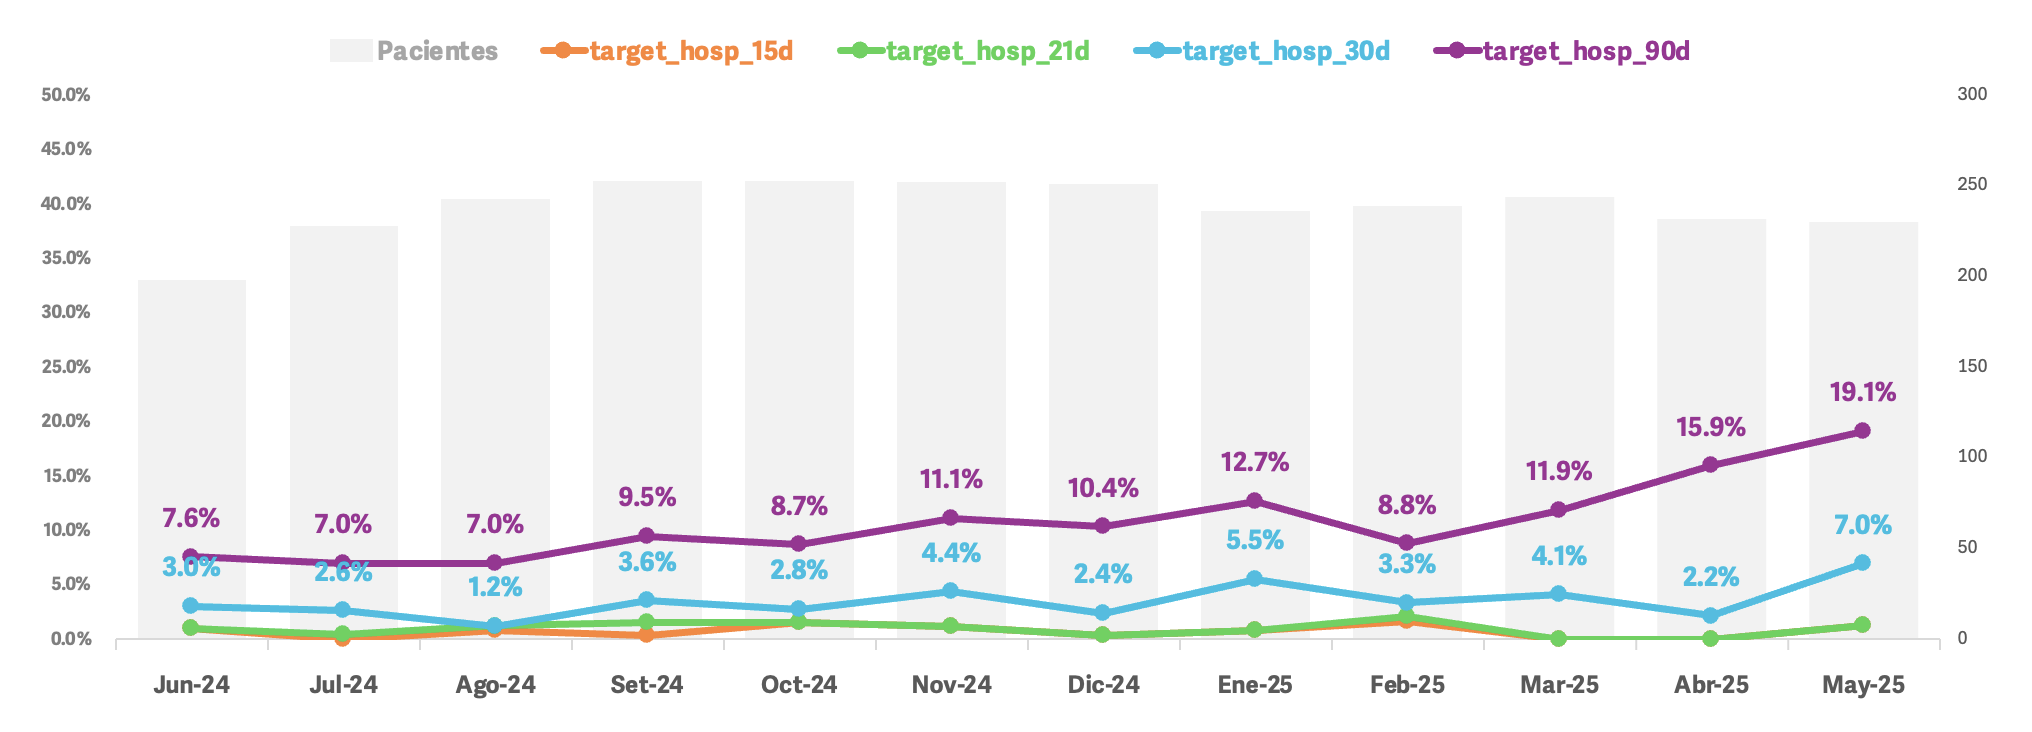

In [34]:
# ---- Configuración ----
df = df_mastertable_v1.copy()

# Detecta qué targets existen realmente en el dataframe
targets = [c for c in ["target_hosp_15d","target_hosp_21d","target_hosp_30d","target_hosp_90d"] if c in df.columns]
assert "CODMES" in df.columns, "Falta la columna CODMES (YYYYMM o fecha)."
assert len(targets)>0, "No se encontraron columnas de target."

# Asegura formato de CODMES (si viene como fecha, pásalo a YYYYMM)
if not pd.api.types.is_integer_dtype(df["CODMES"]) and not pd.api.types.is_object_dtype(df["CODMES"]):
    df["CODMES"] = pd.to_datetime(df["CODMES"]).dt.to_period("M").astype(str).str.replace("-", "").astype(int)

# Pasa a formato largo: una fila por paciente-mes-target
long = df[["CODMES"] + targets].melt(id_vars="CODMES", var_name="target", value_name="y")
# Asume binario {0,1}; en caso de nulos, trátalos como 0 (no evento)
long["y"] = long["y"].fillna(0).astype(int)

# Agregación por CODMES y target
mat = (long
       .groupby(["CODMES","target"], as_index=False)
       .agg(n=("y","size"),
            positivos=("y","sum"))
      )
mat["materialidad_pct"] = (mat["positivos"] / mat["n"] * 100).round(3)

# Orden cronológico y columnas ordenadas
mat = mat.sort_values(["target","CODMES"], ascending=[True, True])[["target","CODMES","n","positivos","materialidad_pct"]]

# (Opcional) marca meses sin positivos para seguimiento
mat["sin_positivos"] = (mat["positivos"]==0)

print("Materialidad del target por mes:")
print(mat.to_string(index=False))


Materialidad del target por mes:
         target  CODMES   n  positivos  materialidad_pct  sin_positivos
target_hosp_15d 2024-06 198          2             1.010          False
target_hosp_15d 2024-07 228          0             0.000           True
target_hosp_15d 2024-08 243          2             0.823          False
target_hosp_15d 2024-09 253          1             0.395          False
target_hosp_15d 2024-10 253          4             1.581          False
target_hosp_15d 2024-11 252          3             1.190          False
target_hosp_15d 2024-12 251          1             0.398          False
target_hosp_15d 2025-01 236          2             0.847          False
target_hosp_15d 2025-02 239          4             1.674          False
target_hosp_15d 2025-03 244          0             0.000           True
target_hosp_15d 2025-04 232          0             0.000           True
target_hosp_15d 2025-05 230          3             1.304          False
target_hosp_21d 2024-06 198    

**3.3 Análisis de Correlación**

**Metodologia:**

Aplicamos un filtro de colinealidad con umbral estricto ∣r∣≥0.95 (Pearson) sobre las variables numéricas. A partir de los 318 pares altamente correlacionados (que involucraron 96 variables únicas), construimos un grafo no dirigido donde cada nodo es una variable y cada arista representa un par con ∣r∣≥0.95. Seleccionamos un conjunto independiente maximal mediante una heurística “low-degree first” (prioriza variables con menor número de conexiones), garantizando que las variables retenidas no presenten entre sí correlaciones por encima del umbral. Este enfoque es reproducible, rápido y no requiere la variable objetivo; además, reduce la redundancia lineal y mitiga la inflación de varianza (VIF) en modelos posteriores.

**Resultados:**

El procedimiento identificó 318 pares con ∣r∣≥0.95, abarcando 96 variables. La selección grafo-basada retuvo 57 variables que no están correlacionadas entre sí por encima del umbral, y marcó 39 como candidatas a retiro dentro del conjunto altamente correlacionado. Esta depuración reduce la multicolinealidad y preserva la diversidad informacional de los predictores.

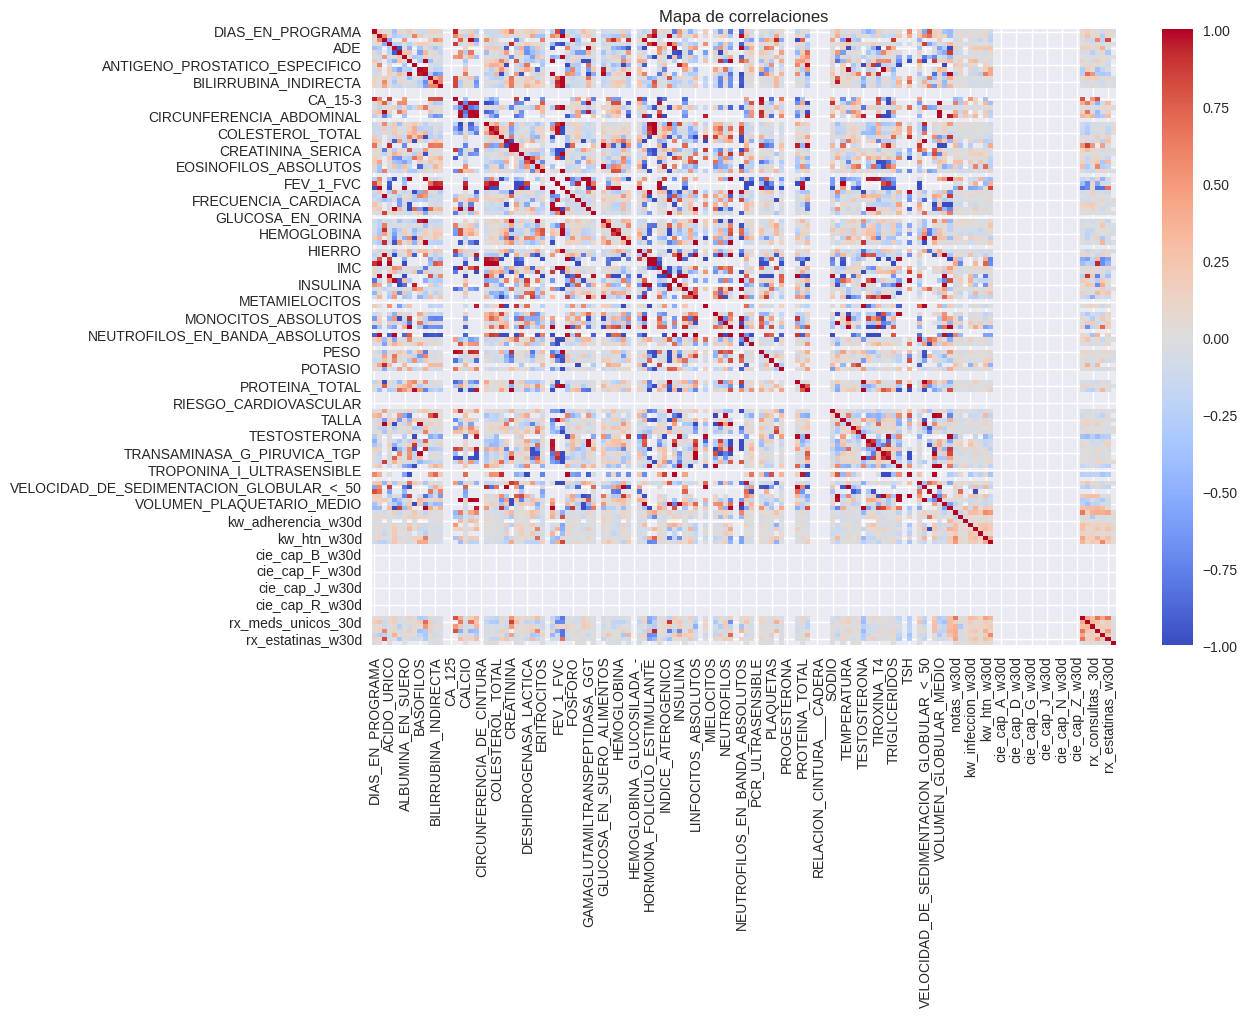

In [35]:
corr = df_mastertable_v1[numeric_features].corr(method="pearson")
plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap="coolwarm", center=0, annot=False)
plt.title("Mapa de correlaciones")
plt.show()

In [36]:
# Creamos una lista de correlaciones
# Listado de pares con |corr| >= 0.95
thr = 0.95

# máscara triángulo superior sin diagonal para evitar duplicados
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
pairs = (
    corr.where(mask)            # deja NaN donde no queremos
        .stack()                # a formato largo (var1, var2, corr)
        .reset_index()
        .rename(columns={"level_0":"var1", "level_1":"var2", 0:"corr"})
)

high_pairs = pairs[(pairs["corr"] >= thr) | (pairs["corr"] <= -thr)].copy()
high_pairs["abs_corr"] = high_pairs["corr"].abs()
high_pairs = high_pairs.sort_values("abs_corr", ascending=False)

Aplicando un umbral estricto de colinealidad |r|≥0.95, identificamos 318 pares que involucran 96 variables. Para garantizar independencia lineal entre predictores y mejorar la estabilidad de los modelos, utilizamos un enfoque grafo-basado que selecciona un conjunto independiente máximo por heurística de menor grado. Este procedimiento retuvo 57 variables que no presentan correlaciones r≥0.95 entre sí, reduciendo la redundancia sin comprometer la diversidad de información.

In [37]:
# Aplicamos Grafos para quedarnos con cierta variables no correlacionadas
# Grafo
adj = defaultdict(set)
for _, r in high_pairs.iterrows():
    a, b = r["var1"], r["var2"]
    adj[a].add(b); adj[b].add(a)

# Heurística: low-degree first (independent set)
ordered = sorted(adj, key=lambda n: (len(adj[n]), n))
keep, banned = set(), set()
for n in ordered:
    if n in banned:
        continue
    if all(n not in adj[s] for s in keep):
        keep.add(n); banned.update(adj[n])

vars_finales = sorted(keep)

In [ ]:
'''
# Guardar dataframe
base_path = Path("/content/drive/MyDrive/Colab Notebooks/MNA/TC5035 - Proyecto Integrador/Semana 4/Resultados")
base_path.mkdir(parents=True, exist_ok=True)

# Matriz de Correlación de Pearson
corr.to_excel(base_path / "Matriz_Correlacion_Pearson.xlsx", index=True)

# Lista de Variables con Alta Correlación
out_csv = base_path / "Correlaciones_Altas_±95.csv"
high_pairs.to_csv(out_csv, index=False, encoding="utf-8-sig")

# Lista de Variables a Retener
out_path = base_path / "Lista_Variables_Retenerlas.xlsx"

df_vars = pd.DataFrame({"variable": vars_finales})
df_vars.index = df_vars.index + 1
df_vars.index.name = "N"

df_vars.to_excel(out_path)
'''

'\n# Guardar dataframe\nbase_path = Path("/content/drive/MyDrive/Colab Notebooks/MNA/TC5035 - Proyecto Integrador/Semana 4/Resultados")\nbase_path.mkdir(parents=True, exist_ok=True)\n\n# Matriz de Correlación de Pearson\ncorr.to_excel(base_path / "Matriz_Correlacion_Pearson.xlsx", index=True)\n\n# Lista de Variables con Alta Correlación\nout_csv = base_path / "Correlaciones_Altas_±95.csv"\nhigh_pairs.to_csv(out_csv, index=False, encoding="utf-8-sig")\n\n# Lista de Variables a Retener\nout_path = base_path / "Lista_Variables_Retenerlas.xlsx"\n\ndf_vars = pd.DataFrame({"variable": vars_finales})\ndf_vars.index = df_vars.index + 1\ndf_vars.index.name = "N"\n\ndf_vars.to_excel(out_path)\n'

**3.4 Identificación de Valores Atípicos**

**Metodologia:**

Para cada variable X, se calculan los cuartiles Q1(25%) y Q3(75%); el rango intercuartílico es IQR=Q3−Q1.

Se definen “cercas” (fences) no paramétricas:
*   Atípico moderado si X<Q1-1.5IQR o X>Q3+1.5IQR
*   Atípico severo si X<Q1-3IQR o X>Q3+3iQR

El criterio es robusto (no asume normalidad) y poco sensible a valores extremos puntuales al basarse en cuartiles.

Se complementa con z-score robusto zr=0.6745X−mediana)/MAD; se marca atípico si |zr|>3.5. Este umbral es estándar y mantiene invarianza a escala y desplazamiento incluso con colas pesadas.

**Resultados:**

La criticidad por atípicos se evaluó combinando tres métricas: %out_iqr15 (amplitud de atípicos moderados), %out_iqr3 (severidad de extremos) y %out_rz (robusto a asimetría). Se priorizó como críticas las variables con %out_iqr15 ≥ 10%. Es decir, 17 variables (>10% de outliers).

Además, existe concentración de atípicos en un subconjunto de variables clínicas (p. ej., hormonas, hemograma diferencial, microalbuminuria) y algunas de gestión (kw_dolor_w30d, rx_estatinas_w30d).

La coincidencia entre IQR y z-robusto sugiere asimetrías/colas pesadas típicas (valores extremadamente altos) más que simples errores uniformes.

Las 21 variables con MAD=0 son candidatas a baja variabilidad (constantes o cuasi-constantes): conviene monitorearlas por utilidad predictiva y posible remoción si no aportan.

In [38]:
# Configuramos las funcionan a usar
try:
    num_cols = list(numeric_features)
except NameError:
    num_cols = df_mastertable_v1.select_dtypes(include=np.number).columns.tolist()

# Función de resumen global de outliers
def resumen_outliers_global(df, cols, thr_rz=3.5):
    rows = []
    for c in cols:
        s = pd.to_numeric(df[c], errors="coerce")
        s2 = s.dropna()
        n = len(s2)

        out15 = out3 = outrz = 0
        if n > 0:
            # IQR
            q1, q3 = s2.quantile([0.25, 0.75])
            iqr = q3 - q1
            if pd.notna(iqr) and iqr > 0:
                low15, up15 = q1 - 1.5*iqr, q3 + 1.5*iqr
                low3,  up3  = q1 - 3.0*iqr, q3 + 3.0*iqr
                out15 = ((s2 < low15) | (s2 > up15)).sum()
                out3  = ((s2 < low3)  | (s2 > up3)).sum()

            # z-score robusto
            med = s2.median()
            mad = (s2 - med).abs().median()
            if pd.notna(mad) and mad > 0:
                zrob = 0.6745 * (s2 - med) / mad
                outrz = (zrob.abs() > thr_rz).sum()

        rows.append({
            "variable": c,
            "n_no_nulo": n,
            "out_iqr15": out15,
            "%out_iqr15": out15 / n if n else np.nan,
            "out_iqr3": out3,
            "%out_iqr3": out3 / n if n else np.nan,
            "out_rz": outrz,
            "%out_rz": outrz / n if n else np.nan,
        })

    return pd.DataFrame(rows).sort_values("%out_iqr15", ascending=False)

In [39]:
# Reporte de Atípicos General
outliers_global = resumen_outliers_global(df_mastertable_v1, num_cols)
outliers_global.head(5)

,variable,n_no_nulo,out_iqr15,%out_iqr15,out_iqr3,%out_iqr3,out_rz,%out_rz
65,MICROALBUMINURIA,163,37,0.226994,28,0.171779,43,0.263804
32,EOSINOFILOS_ABSOLUTOS,32,7,0.218750,7,0.218750,7,0.218750
91,T4_LIBRE,55,12,0.218182,9,0.163636,9,0.163636
110,VOLUMEN_CORPUSCULAR_MEDIO,60,13,0.216667,2,0.033333,2,0.033333
118,kw_dolor_w30d,2173,452,0.208007,395,0.181776,0,0.000000


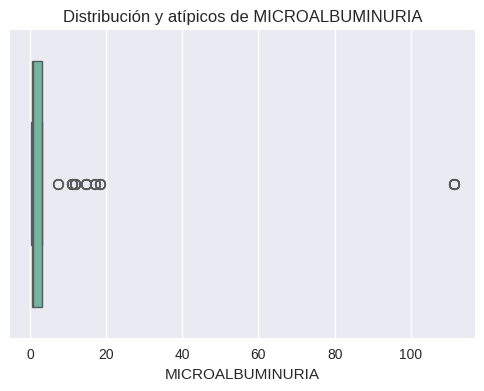

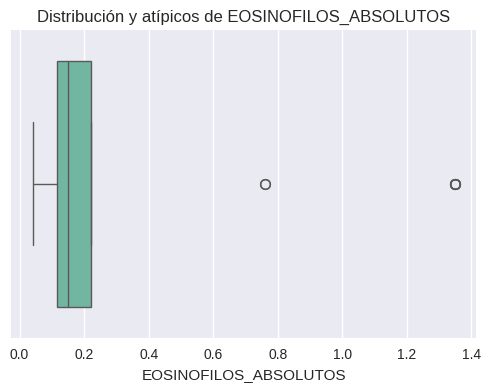

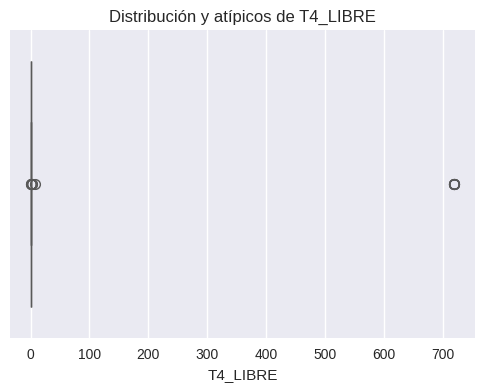

In [40]:
# Boxplot ejemplo para biomarcadores críticos
biomarkers_to_check = ["MICROALBUMINURIA", "EOSINOFILOS_ABSOLUTOS", "T4_LIBRE"]
for col in biomarkers_to_check:
    if col in df_mastertable_v1.columns:
        plt.figure(figsize=(6,4))
        sns.boxplot(x=df_mastertable_v1[col])
        plt.title(f"Distribución y atípicos de {col}")
        plt.show()

In [ ]:
'''
# Guardar dataframe
base_path = Path("/content/drive/MyDrive/Colab Notebooks/MNA/TC5035 - Proyecto Integrador/Semana 4/Resultados")
base_path.mkdir(parents=True, exist_ok=True)

# Analisis de Outliers
outliers_global.to_excel(base_path / "EDA_Outliers_Univariado_Global.xlsx", index=True)
'''

## **4. Ingeniería de Características (FE) y Preparación de Datos (CRISP-ML)**

**4.1 Construcción del Dataset Final**

*   El dataset modelable se construyó a nivel paciente-mes anclado en FECHA_MES_5 e identificado por ID_EHT, FECHA_MES_5 y CODMES.

*   Los eventos a predecir son cuatro horizontes de hospitalización binarios: target_hosp_15d, target_hosp_21d, target_hosp_30d, target_hosp_90d.

*   Las 59 variables incluyen analíticas, signos vitales, demografía y señales conductuales y textuales (p. ej., rx_*, kw_*, notas_*), todas calculadas exclusivamente con información anterior a FECHA_MES_5 para evitar leakage.

In [41]:
# --- Columnas base ---
cols_base = ["ID_EHT", "FECHA_MES_5", "CODMES"]

# --- Eventos a predecir ---
targets = ["target_hosp_15d","target_hosp_21d","target_hosp_30d","target_hosp_90d"]

# --- Lista de variables seleccionadas ---
cols_vars = [
    "ACIDO_URICO","ALBUMINA","ALBUMINA_EN_SUERO","BILIRRUBINA_DIRECTA","BILIRRUBINA_INDIRECTA",
    "BILIRRUBINA_TOTAL","CALCIO","COLESTEROL_HDL","COLESTEROL_LDL","COLESTEROL_TOTAL","COLESTEROL_VLDL",
    "CREATININA_SERICA","DENSIDAD","DESHIDROGENASA_LACTICA","ERITROCITOS","FOSFATA_ALCALINA","FOSFORO",
    "GLOBULINA","GLUCOSA_EN_SUERO_AYUNO","HEMATOCRITOS","HEMOGLOBINA","HEMOGLOBINA_GLUCOSILADA_HBA1C",
    "HIERRO","IMC","INDICE_ATEROGENICO","LEUCOCITOS_TOTALES","NITROGENO_UREICO_BUN","OXIMETRIA_CAPILAR",
    "PESO","PH","PLAQUETAS","POTASIO","PROTEINA_C_REACTIVA","PROTEINA_TOTAL","SODIO","TALLA",
    "TENSION_ARTERIAL_SISTOLICA","TRIGLICERIDOS","TENSION_ARTERIAL_DIASTOLICA","DIAS_EN_PROGRAMA","EDAD",
    "GENERO","UBICACION","rx_w30d","rx_meds_unicos_30d","rx_consultas_30d","rx_polifarmacia_30d",
    "rx_estatinas_w30d","rx_antibioticos_w30d","rx_antihipertensivos_w30d","rx_antidiabeticos_w30d",
    "notas_w30d","tokens_notas_w30d","kw_adherencia_w30d","kw_infeccion_w30d","kw_fiebre_w30d",
    "kw_htn_w30d","kw_dolor_w30d","kw_dm_w30d"
]

# --- Combinar columnas existentes ---
cols_final = [c for c in cols_base + targets + cols_vars if c in df_mastertable_v1.columns]

# --- Crear el nuevo dataframe filtrado ---
df_selected = df_mastertable_v1[cols_final].copy()

# --- Verificación ---
print("Total de columnas seleccionadas:", len(cols_final))
print("Primeras columnas:", cols_final[:8])
print("Últimas columnas:", cols_final[-8:])

Total de columnas seleccionadas: 66
Primeras columnas: ['ID_EHT', 'FECHA_MES_5', 'CODMES', 'target_hosp_15d', 'target_hosp_21d', 'target_hosp_30d', 'target_hosp_90d', 'ACIDO_URICO']
Últimas columnas: ['notas_w30d', 'tokens_notas_w30d', 'kw_adherencia_w30d', 'kw_infeccion_w30d', 'kw_fiebre_w30d', 'kw_htn_w30d', 'kw_dolor_w30d', 'kw_dm_w30d']


**4.2 Procesamiento y transformación**

**4.2.0 Split Temporal**

Split temporal (antes de cualquier transformación) para evitar fuga de información:
*   Train:    CODMES 202406–202412
*   Valid:    CODMES 202501–202502
*   Test:     CODMES 202503–202505

Todas las decisiones de imputación se ajustan (fit) únicamente en Train y se aplican (transform) a Valid y Test sin recalcular parámetros.

In [42]:
# ------------------------------
# Convertimos CODMES a entero
# ------------------------------
def codmes_to_int(serie: pd.Series) -> pd.Series:
    """Convierte CODMES a entero YYYYMM (nullable Int64).
       Acepta formatos: 202406, '2024-06', '2024/6', '2024 06', etc.
    """
    s = serie.astype(str).str.strip()

    # Normalizar separadores a '-'
    s = s.str.replace(r"[./_ ]+", "-", regex=True)

    # Si viene como 6 dígitos (YYYYMM), inserta guion para parsear
    mask_6 = s.str.fullmatch(r"\d{6}")
    s_loc = s.copy()
    s_loc.loc[mask_6] = s.loc[mask_6].str.slice(0,4) + "-" + s.loc[mask_6].str.slice(4,6)

    # Asegurar cero a la izquierda del mes (YYYY-M -> YYYY-0M)
    s_loc = s_loc.str.replace(r"^(\d{4})-(\d{1})$", r"\1-0\2", regex=True)

    # Parsear a fecha (primer día del mes) y convertir a entero YYYYMM
    dt = pd.to_datetime(s_loc, format="%Y-%m", errors="coerce")
    if dt.isna().any():
        # opcional: inspeccionar algunos valores problemáticos
        bad = s.loc[dt.isna()].unique()[:10]
        print(f"[Aviso] CODMES no parseable (muestra): {bad}")

    cod_int = (dt.dt.year * 100 + dt.dt.month).astype("Int64")  # nullable Int64
    return cod_int

# ---- Uso ----
df = df_selected.copy()
df["CODMES_INT"] = codmes_to_int(df["CODMES"])

# Guardar el índice (posición) original de CODMES
pos_codmes = df.columns.get_loc("CODMES")
# Tomar la serie nueva (evita perderla al dropear columnas)
codmes_new = df["CODMES_INT"]
# Eliminar la columna CODMES original
df = df.drop(columns=["CODMES"])
# Insertar la nueva columna en la misma posición con el mismo nombre
df.insert(pos_codmes, "CODMES", codmes_new)
# Eliminar la columna auxiliar
df = df.drop(columns=["CODMES_INT"])

df_selectedvf = df.copy()

In [43]:
# ----------------------------
# Entradas esperadas
# ----------------------------
# df_selected: DataFrame con:
#   - Identificadores: ["ID_EHT","FECHA_MES_5","CODMES"]
#   - Targets:         ["target_hosp_15d","target_hosp_21d","target_hosp_30d","target_hosp_90d"]
#   - Features ya depuradas (59 vars)

id_cols    = ["ID_EHT","FECHA_MES_5","CODMES"]
target_cols = ["target_hosp_15d","target_hosp_21d","target_hosp_30d","target_hosp_90d"]

# ----------------------------
# Split temporal (sin fuga)
# ----------------------------
train_mask = df_selectedvf["CODMES"].isin([202406, 202407, 202408, 202409, 202410, 202411, 202412])
val_mask   = df_selectedvf["CODMES"].isin([202501, 202502])
test_mask  = df_selectedvf["CODMES"].isin([202503, 202504, 202505])

# Sanity checks
assert not (train_mask & val_mask).any()
assert not (train_mask & test_mask).any()
assert not (val_mask & test_mask).any()

df_train = df_selectedvf.loc[train_mask].copy()
df_val   = df_selectedvf.loc[val_mask].copy()
df_test  = df_selectedvf.loc[test_mask].copy()

print(f"Train: {df_train.shape} | Val: {df_val.shape} | Test: {df_test.shape}")


Train: (1678, 66) | Val: (475, 66) | Test: (706, 66)


**4.2.1 Imputación robusta de datos**

Siguiendo CRISP-ML, antes de cualquier transformación se realizó un split temporal para evitar fuga de información: Train (202406–202412), Validación (202501–202502) y Test (202503–202505). Las dimensiones resultantes fueron: Train = 1 678 filas, Valid = 475, Test = 706. Todos los hiperparámetros de imputación se ajustaron exclusivamente en Train y se aplicaron sin re-estimación a Valid/Test.

Previo a la imputación se observó una ausencia sustantiva en varios biomarcadores de baja frecuencia clínica en Train (p. ej., Deshidrogenasa Láctica ≈ 96.5%, Colesterol VLDL ≈ 93.6%, Albúmina ≈ 92.7%, Fosfatasa Alcalina ≈ 85.9%). Esto justificó el uso de estrategias robustas:


**1.   Numéricas:** imputación por mediana (estimada en Train). Muestra de parámetros aprendidos:
ACIDO_URICO = 5.50, ALBUMINA = 4.32, ALBUMINA_EN_SUERO = 4.30, BILIRRUBINA_DIRECTA = 0.23, BILIRRUBINA_INDIRECTA = 0.38, BILIRRUBINA_TOTAL = 0.617, CALCIO = 9.40, COLESTEROL_HDL = 46.6.
Esta elección minimiza la influencia de colas pesadas y valores extremos típicos de mediciones clínicas.

**2.   Categóricas:** imputación por moda (ajustada en Train) con fallback documentado a “Desconocido” si la columna estaba vacía. Muestra:
GENERO = 'M', UBICACION = 'Monterrey', rx_polifarmacia_30d = 1.0.

En resumen, la combinación de partición temporal estricta y imputación robusta (mediana/moda estimadas en Train) produjo un dataset libre de valores faltantes y con parámetros de imputación trazables, preservando la validez temporal y preparando el terreno para las siguientes etapas (tratamiento de outliers y transformaciones, codificación, escalamiento y selección).

###### **Nota: Esta es la primera implementación de imputación para df_selected. Sirve como referencia inicial para manejar valores faltantes y outliers.**

###### **Durante la experimentación con modelos de ML, es posible regresar a esta versión para comparar resultados, ajustar métodos de imputación o probar diferentes estrategias según desempeño predictivo.**

In [44]:
# ----------------------------
# Identificación de tipos
# ----------------------------
feature_cols = [c for c in df_selectedvf.columns if c not in (set(id_cols) | set(target_cols))]
cat_cols = categorical_features
num_cols = [c for c in feature_cols
            if c not in cat_cols
            and pd.api.types.is_numeric_dtype(df_selectedvf[c])]

print(f"Numéricas: {len(num_cols)}  |  Categóricas: {len(cat_cols)}")

Numéricas: 56  |  Categóricas: 3


In [45]:
# ----------------------------
# Reporte de faltantes
# ----------------------------
def missing_report(df, cols, title):
    miss = df[cols].isna().mean().sort_values(ascending=False)
    print(f"\n[Missing {title}] columnas con NA > 0:")
    print(miss[miss>0].head(15))

missing_report(df_train, feature_cols, "Train (antes)")


[Missing Train (antes)] columnas con NA > 0:
DESHIDROGENASA_LACTICA           0.965435
COLESTEROL_VLDL                  0.936234
ALBUMINA                         0.926698
FOSFATA_ALCALINA                 0.858760
INDICE_ATEROGENICO               0.853397
FOSFORO                          0.815852
PROTEINA_C_REACTIVA              0.800954
HEMOGLOBINA_GLUCOSILADA_HBA1C    0.771156
PLAQUETAS                        0.702026
PH                               0.682956
DENSIDAD                         0.676996
COLESTEROL_LDL                   0.663886
PROTEINA_TOTAL                   0.663290
IMC                              0.660906
TALLA                            0.660906
dtype: float64


In [46]:
# -------------------------------------------------
# IMPUTACIÓN NUMÉRICA por MEDIANA (fit en TRAIN)
# -------------------------------------------------
num_medians = df_train[num_cols].median(numeric_only=True).to_dict()

def impute_numeric_inplace(df, num_cols, medians):
    out = df.copy()
    for c in num_cols:
        out[c] = out[c].fillna(medians[c])
    return out

df_train = impute_numeric_inplace(df_train, num_cols, num_medians)
df_val   = impute_numeric_inplace(df_val,   num_cols, num_medians)
df_test  = impute_numeric_inplace(df_test,  num_cols, num_medians)

In [47]:
# -------------------------------------------------
# IMPUTACIÓN CATEGÓRICA por MODA (fit en TRAIN)
# -------------------------------------------------
def compute_cat_modes(df_train, cat_cols):
    """
    Calcula la moda por columna categórica en TRAIN.
    Si toda la columna está vacía en TRAIN, usa 'Desconocido' como fallback documentado.
    """
    modes = {}
    for c in cat_cols:
        # trata cadenas vacías/espacios como NaN ANTES de calcular la moda
        col = df_train[c].astype("object").replace(r"^\s*$", np.nan, regex=True)
        if col.dropna().empty:
            modes[c] = "Desconocido"  # fallback explícito y documentado
        else:
            modes[c] = col.mode(dropna=True).iloc[0]
    return modes

cat_modes = compute_cat_modes(df_train, cat_cols)

def impute_categorical_by_mode(df, cat_cols, mode_map):
    out = df.copy()
    for c in cat_cols:
        out[c] = out[c].astype("object").replace(r"^\s*$", np.nan, regex=True)
        out[c] = out[c].fillna(mode_map[c])
    return out

df_train = impute_categorical_by_mode(df_train, cat_cols, cat_modes)
df_val   = impute_categorical_by_mode(df_val,   cat_cols, cat_modes)
df_test  = impute_categorical_by_mode(df_test,  cat_cols, cat_modes)


In [48]:
# ============================================================
# Reporte de Control - Post Imputacion
# Metodología:
# - Verifica que no queden NA en features por split (train/val/test).
# - Muestra una muestra de medianas/modas aprendidas (fit en TRAIN).
# - Chequea dtypes consistentes y categorías no vistas (drift) en VAL/TEST.
# Conclusión esperada:
# - Splits sin NA en features, parámetros de imputación trazables y
#   ausencia de categorías nuevas relevantes (o, si existen, listarlas).
# ============================================================

def missing_summary(df, feature_cols, name):
    miss_rate = df[feature_cols].isna().mean()
    total_na = miss_rate.sum()
    if total_na == 0:
        print(f"{name}: OK, 0 valores faltantes en features.")
    else:
        print(f"{name}: Atención, existen faltantes. Top columnas con NA:")
        print((miss_rate[miss_rate>0]*100).sort_values(ascending=False).head(10).round(2).astype(str) + "%")

def dtype_summary(df, num_cols, cat_cols, name):
    bad_num = [c for c in num_cols if not pd.api.types.is_numeric_dtype(df[c])]
    bad_cat = [c for c in cat_cols if pd.api.types.is_numeric_dtype(df[c])]
    if not bad_num and not bad_cat:
        print(f"{name}: dtypes OK (numéricas y categóricas consistentes).")
    else:
        if bad_num:
            print(f"{name}: columnas numéricas con dtype no numérico -> {bad_num}")
        if bad_cat:
            print(f"{name}: columnas categóricas con dtype numérico -> {bad_cat}")

def unseen_categories(train_df, other_df, cat_cols, other_name, max_cols=5, max_vals=5):
    drift = {}
    for c in cat_cols:
        tr = set(train_df[c].astype(str).unique())
        ot = set(other_df[c].astype(str).unique())
        unseen = sorted(list(ot - tr))
        if unseen:
            drift[c] = unseen[:max_vals]
    if drift:
        print(f"{other_name}: categorías no vistas en TRAIN (muestra):")
        for i, (c, cats) in enumerate(drift.items()):
            if i >= max_cols: break
            print(f"  - {c}: {cats}")
    else:
        print(f"{other_name}: sin categorías nuevas respecto a TRAIN.")

def control_report(df_train, df_val, df_test,
                   feature_cols, num_cols, cat_cols,
                   num_medians, cat_modes):
    # Shapes
    print(f"Shapes -> Train: {df_train.shape} | Val: {df_val.shape} | Test: {df_test.shape}")

    # Missing por split
    missing_summary(df_train, feature_cols, "TRAIN")
    missing_summary(df_val,   feature_cols, "VALID")
    missing_summary(df_test,  feature_cols, "TEST")

    # Dtypes consistentes
    dtype_summary(df_train, num_cols, cat_cols, "TRAIN")
    dtype_summary(df_val,   num_cols, cat_cols, "VALID")
    dtype_summary(df_test,  num_cols, cat_cols, "TEST")

    # Muestra de parámetros de imputación (trazabilidad)
    med_sample = dict(islice(num_medians.items(), 8))
    mode_sample = dict(islice(cat_modes.items(), 8)) if len(cat_cols) > 0 else {}
    print(f"Medianas aprendidas (muestra): {med_sample}")
    if mode_sample:
        print(f"Modas aprendidas (muestra): {mode_sample}")

    # Drift de categorías (VAL/TEST vs TRAIN)
    if len(cat_cols) > 0:
        unseen_categories(df_train, df_val,  cat_cols, "VALID")
        unseen_categories(df_train, df_test, cat_cols, "TEST")

    # Asserts finales (falla si queda NA en features)
    assert df_train[feature_cols].isna().sum().sum() == 0, "TRAIN contiene NA en features post-imputación."
    assert df_val[feature_cols].isna().sum().sum()   == 0, "VALID contiene NA en features post-imputación."
    assert df_test[feature_cols].isna().sum().sum()  == 0, "TEST contiene NA en features post-imputación."
    print("Control OK: sin NA en features y parámetros de imputación registrados.")

# Ejecuta el reporte
control_report(df_train, df_val, df_test,
               feature_cols, num_cols, cat_cols,
               num_medians, cat_modes)


Shapes -> Train: (1678, 66) | Val: (475, 66) | Test: (706, 66)
TRAIN: OK, 0 valores faltantes en features.
VALID: OK, 0 valores faltantes en features.
TEST: OK, 0 valores faltantes en features.
TRAIN: columnas categóricas con dtype numérico -> ['rx_polifarmacia_30d']
VALID: columnas categóricas con dtype numérico -> ['rx_polifarmacia_30d']
TEST: columnas categóricas con dtype numérico -> ['rx_polifarmacia_30d']
Medianas aprendidas (muestra): {'ACIDO_URICO': 5.5, 'ALBUMINA': 4.32, 'ALBUMINA_EN_SUERO': 4.3, 'BILIRRUBINA_DIRECTA': 0.23, 'BILIRRUBINA_INDIRECTA': 0.38, 'BILIRRUBINA_TOTAL': 0.6166666666666667, 'CALCIO': 9.4, 'COLESTEROL_HDL': 46.6}
Modas aprendidas (muestra): {'GENERO': 'M', 'UBICACION': 'Monterrey', 'rx_polifarmacia_30d': np.float64(1.0)}
VALID: sin categorías nuevas respecto a TRAIN.
TEST: categorías no vistas en TRAIN (muestra):
  - UBICACION: ['Cholula']
Control OK: sin NA en features y parámetros de imputación registrados.


**4.2.3 Transformación de Variables**

**Análisis de asimetría**

La asimetría (skewness) mide qué tan simétrica es la distribución de los datos respecto a su media. Según su valor, puede ser necesario aplicar transformaciones para normalizar, lo cual es útil en estadística y machine learning.


- **Asimetría entre -0.5 y 0.5:** La distribución se considera simétrica o cercana a la normal. Generalmente no se requiere transformación (ejemplo: altura de adultos).
- **Asimetría entre 0.5 y 1 (o -0.5 y -1):** Indica sesgo moderado, positivo o negativo. Conviene evaluar una transformación si se usarán métodos sensibles a la normalidad (ejemplo: ingresos mensuales).
- **Asimetría > 1 o < -1:** La distribución está fuertemente sesgada, con colas largas. Aquí es muy recomendable aplicar una transformación (ejemplo: ventas donde pocos clientes concentran la mayoría).

**Transformaciones recomendadas:**

- **Yeo-Johnson:** Esta transformación es la más versátil, ya que puede aplicarse tanto a valores positivos como negativos. Es ideal cuando no se conoce si los datos contienen valores menores que cero. Su principal efecto es reducir la asimetría y estabilizar la varianza de la variable, lo que permite que los modelos estadísticos y de machine learning funcionen de manera más eficiente.
- **Box-Cox:** Muy efectiva para datos estrictamente positivos, esta transformación es especialmente útil para variables como ingresos, cantidades de ventas o medidas físicas. Box-Cox reduce significativamente la asimetría y ayuda a aproximar la distribución a una forma más normal, mejorando la calidad de los análisis estadísticos.
- **Log:** Recomendada para casos de asimetría positiva moderada, la transformación logarítmica comprime los valores grandes y estira ligeramente los más pequeños. Esto suaviza la cola derecha de la distribución y es especialmente útil cuando existen valores atípicos que podrían sesgar los resultados.
- **Sqrt:** Adecuada para asimetrías leves positivas, esta transformación es útil en variables de conteo o frecuencias, como el número de visitas a un sitio web o productos vendidos. Reduce ligeramente el sesgo, suavizando la distribución sin alterar drásticamente la escala de los datos.

- **Transformación exponencial:** Consiste en aplicar una función exponencial a los valores de la variable. Es útil para asimetría negativa, ya que expande los valores bajos y comprime los altos, ayudando a reducir el sesgo y aproximar la distribución a una forma más simétrica. Debe usarse con precaución, pues puede aumentar la escala de los datos.

Durante el análisis exploratorio de datos (EDA) se identificaron variables continuas con distribuciones sesgadas y con un porcentaje considerable de valores faltantes. Con el fin de mejorar su comportamiento estadístico y facilitar el desempeño de los modelos de machine learning, estas variables serán sometidas a técnicas de transformación para aproximarlas a una distribución más simétrica y estable. De este modo, se busca reducir la influencia de valores extremos y optimizar la capacidad predictiva de los algoritmos.

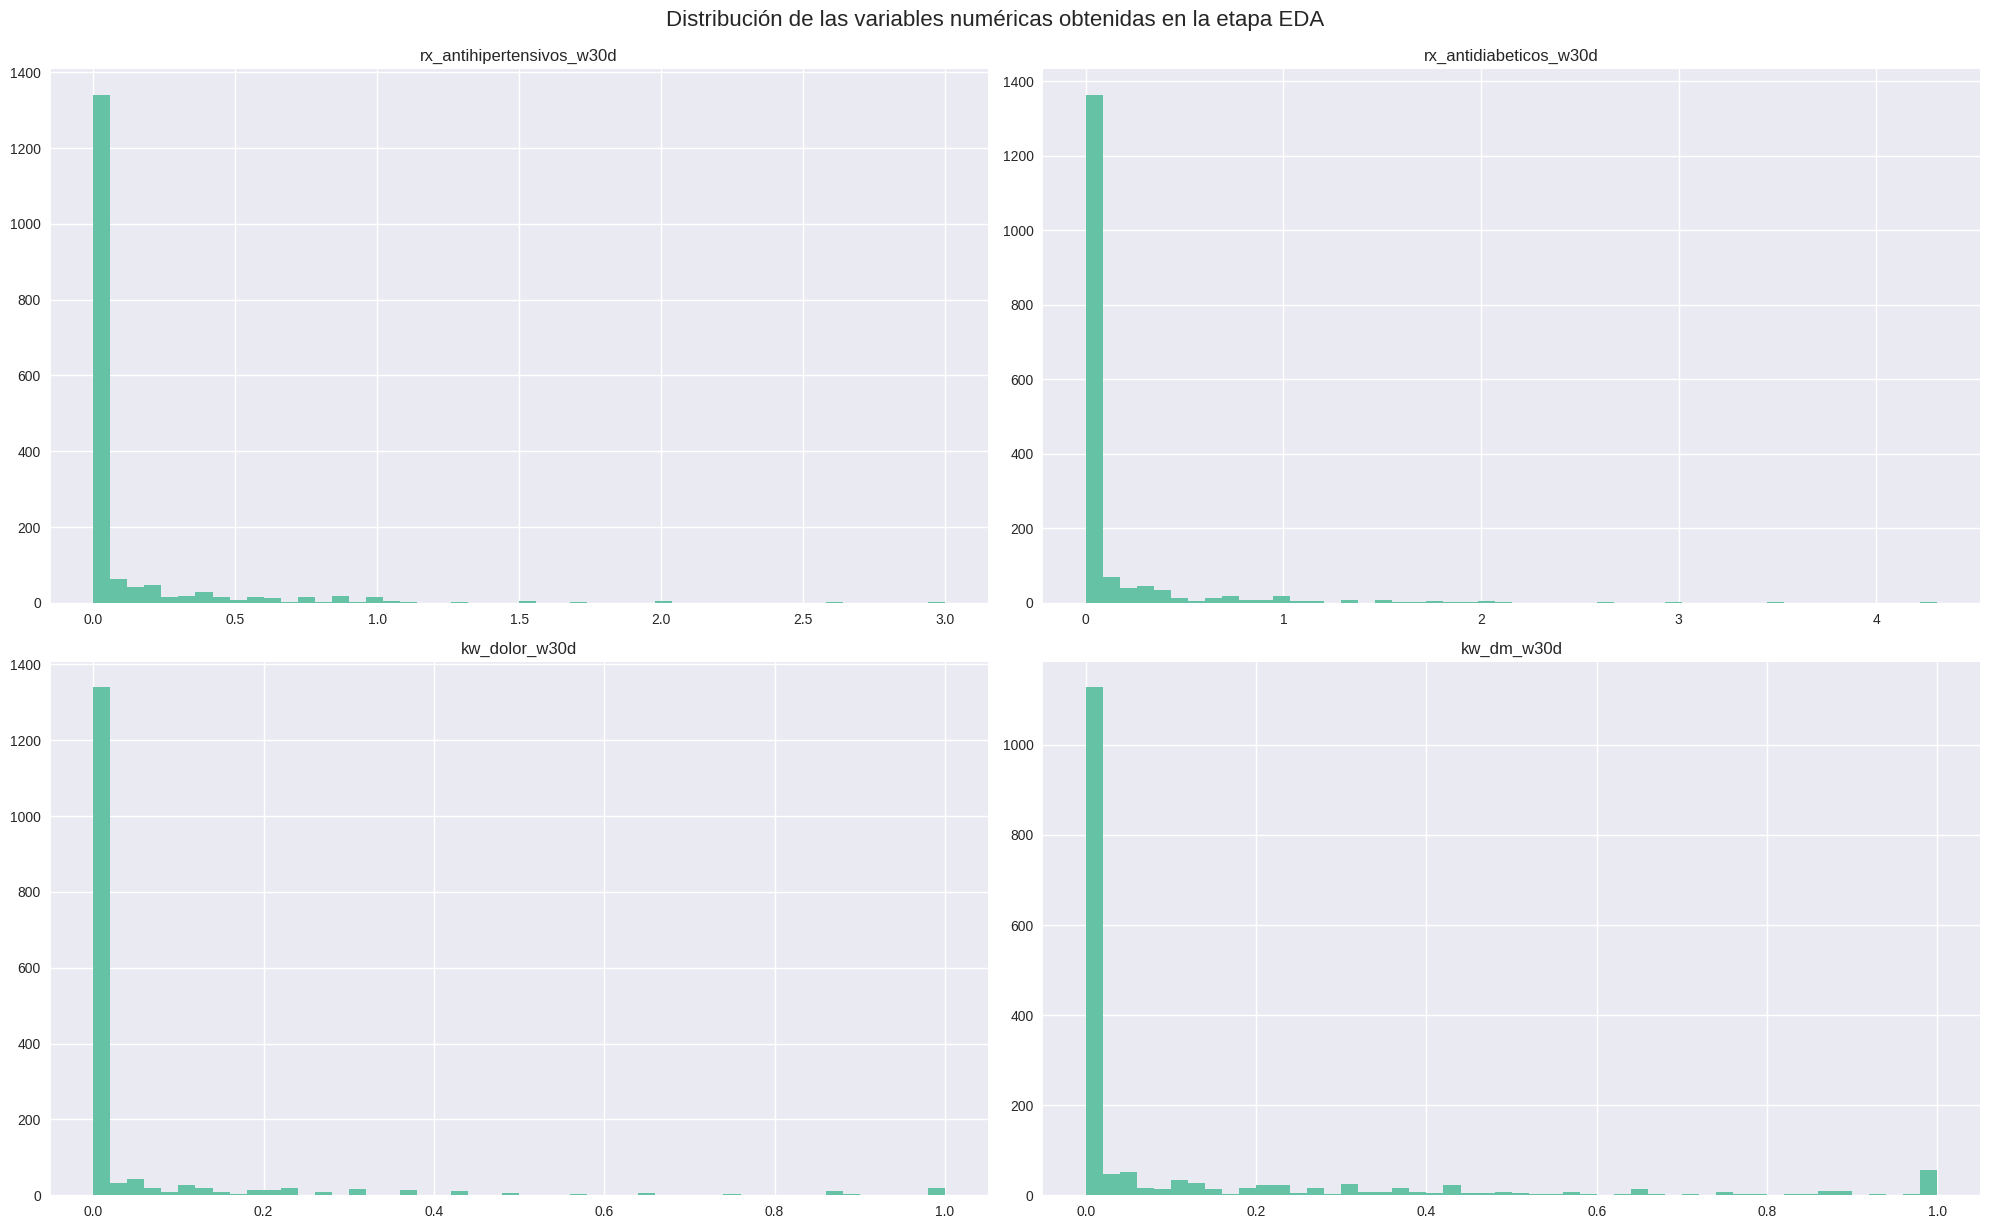

In [49]:
# Selección de columnas
columnas_sesgadas = ['rx_antihipertensivos_w30d', 'rx_antidiabeticos_w30d', 'kw_dolor_w30d', 'kw_dm_w30d']

# Gráfico para visualizar la distribución de las variables numéricas
df_train[columnas_sesgadas].hist(bins=50, figsize=(20, 12))
plt.tight_layout()
plt.suptitle("Distribución de las variables numéricas obtenidas en la etapa EDA", fontsize=16, y=1.02)
plt.show()

In [50]:
# Función para estadísticas de asimetría
def evaluar_asimetria(df):
    """
    Calcula métricas de asimetría para determinar necesidad de transformación
    """
    columnas_numericas = df.select_dtypes(include=[np.number]).columns

    resultados = []
    for col in columnas_numericas:
        data = df[col].dropna()

        skewness = stats.skew(data)
        kurtosis = stats.kurtosis(data)

        # Determinar si necesita transformación
        necesita_trans = abs(skewness) > 1
        tipo_sugerido = ''

        if necesita_trans:
            if skewness > 1:
                tipo_sugerido = 'log, sqrt, box-cox'
            elif skewness < -1:
                tipo_sugerido = 'exponencial, cuadrado'

        resultados.append({
            'Columna': col,
            'Asimetría': round(skewness, 3),
            'Curtosis': round(kurtosis, 3),
            'Necesita Transformación': 'Si' if necesita_trans else 'No',
            'Transformación Sugerida': tipo_sugerido
        })

    return pd.DataFrame(resultados).sort_values('Asimetría', ascending = False)

In [51]:
reporte_asimetrica = evaluar_asimetria(df_train[columnas_sesgadas])
reporte_asimetrica

,Columna,Asimetría,Curtosis,Necesita Transformación,Transformación Sugerida
1,rx_antidiabeticos_w30d,5.068,35.967,Si,"log, sqrt, box-cox"
0,rx_antihipertensivos_w30d,4.610,28.768,Si,"log, sqrt, box-cox"
2,kw_dolor_w30d,3.822,15.120,Si,"log, sqrt, box-cox"
3,kw_dm_w30d,2.396,4.890,Si,"log, sqrt, box-cox"


**Transformación Yeo-Johnson**

La aplicación de la transformación Yeo-Johnson se justifica debido a que la variable presenta una distribución sesgada hacia la derecha, con valores extremos que afectan su simetría y estabilidad. A diferencia de la transformación logarítmica, Yeo-Johnson admite valores iguales o menores que cero, lo cual resulta especialmente adecuado en este caso, ya que la variable contiene una gran cantidad de ceros. Esta transformación permite reducir la dispersión, estabilizar la varianza y aproximar la distribución a una forma más normal, contribuyendo a mejorar la robustez y el rendimiento de los modelos de machine learning.

In [52]:
from sklearn.preprocessing import PowerTransformer

def fit_yeo_johnson(df_train, columnas):
    """
    Ajusta la transformación Yeo-Johnson en train y transforma los datos.
    Devuelve el DataFrame transformado y los transformadores entrenados.
    """
    df_train = df_train.copy()
    transformers = {}

    for columna in columnas:
        pt = PowerTransformer(method='yeo-johnson', standardize=True)
        df_train[columna] = pt.fit_transform(df_train[[columna]])
        transformers[columna] = pt

    return df_train, transformers


def transform_yeo_johnson(df, columnas, transformers):
    """
    Aplica los transformadores Yeo-Johnson entrenados (de train) a test o val.
    """
    df = df.copy()
    for columna in columnas:
        pt = transformers[columna]
        df[columna] = pt.transform(df[[columna]])
    return df

In [53]:
# 1. Ajustar en train
df_train, transformers = fit_yeo_johnson(df_train, columnas_sesgadas)

In [54]:
# 2. Aplicar en val y test
df_val = transform_yeo_johnson(df_val, columnas_sesgadas, transformers)
df_test = transform_yeo_johnson(df_test, columnas_sesgadas, transformers)

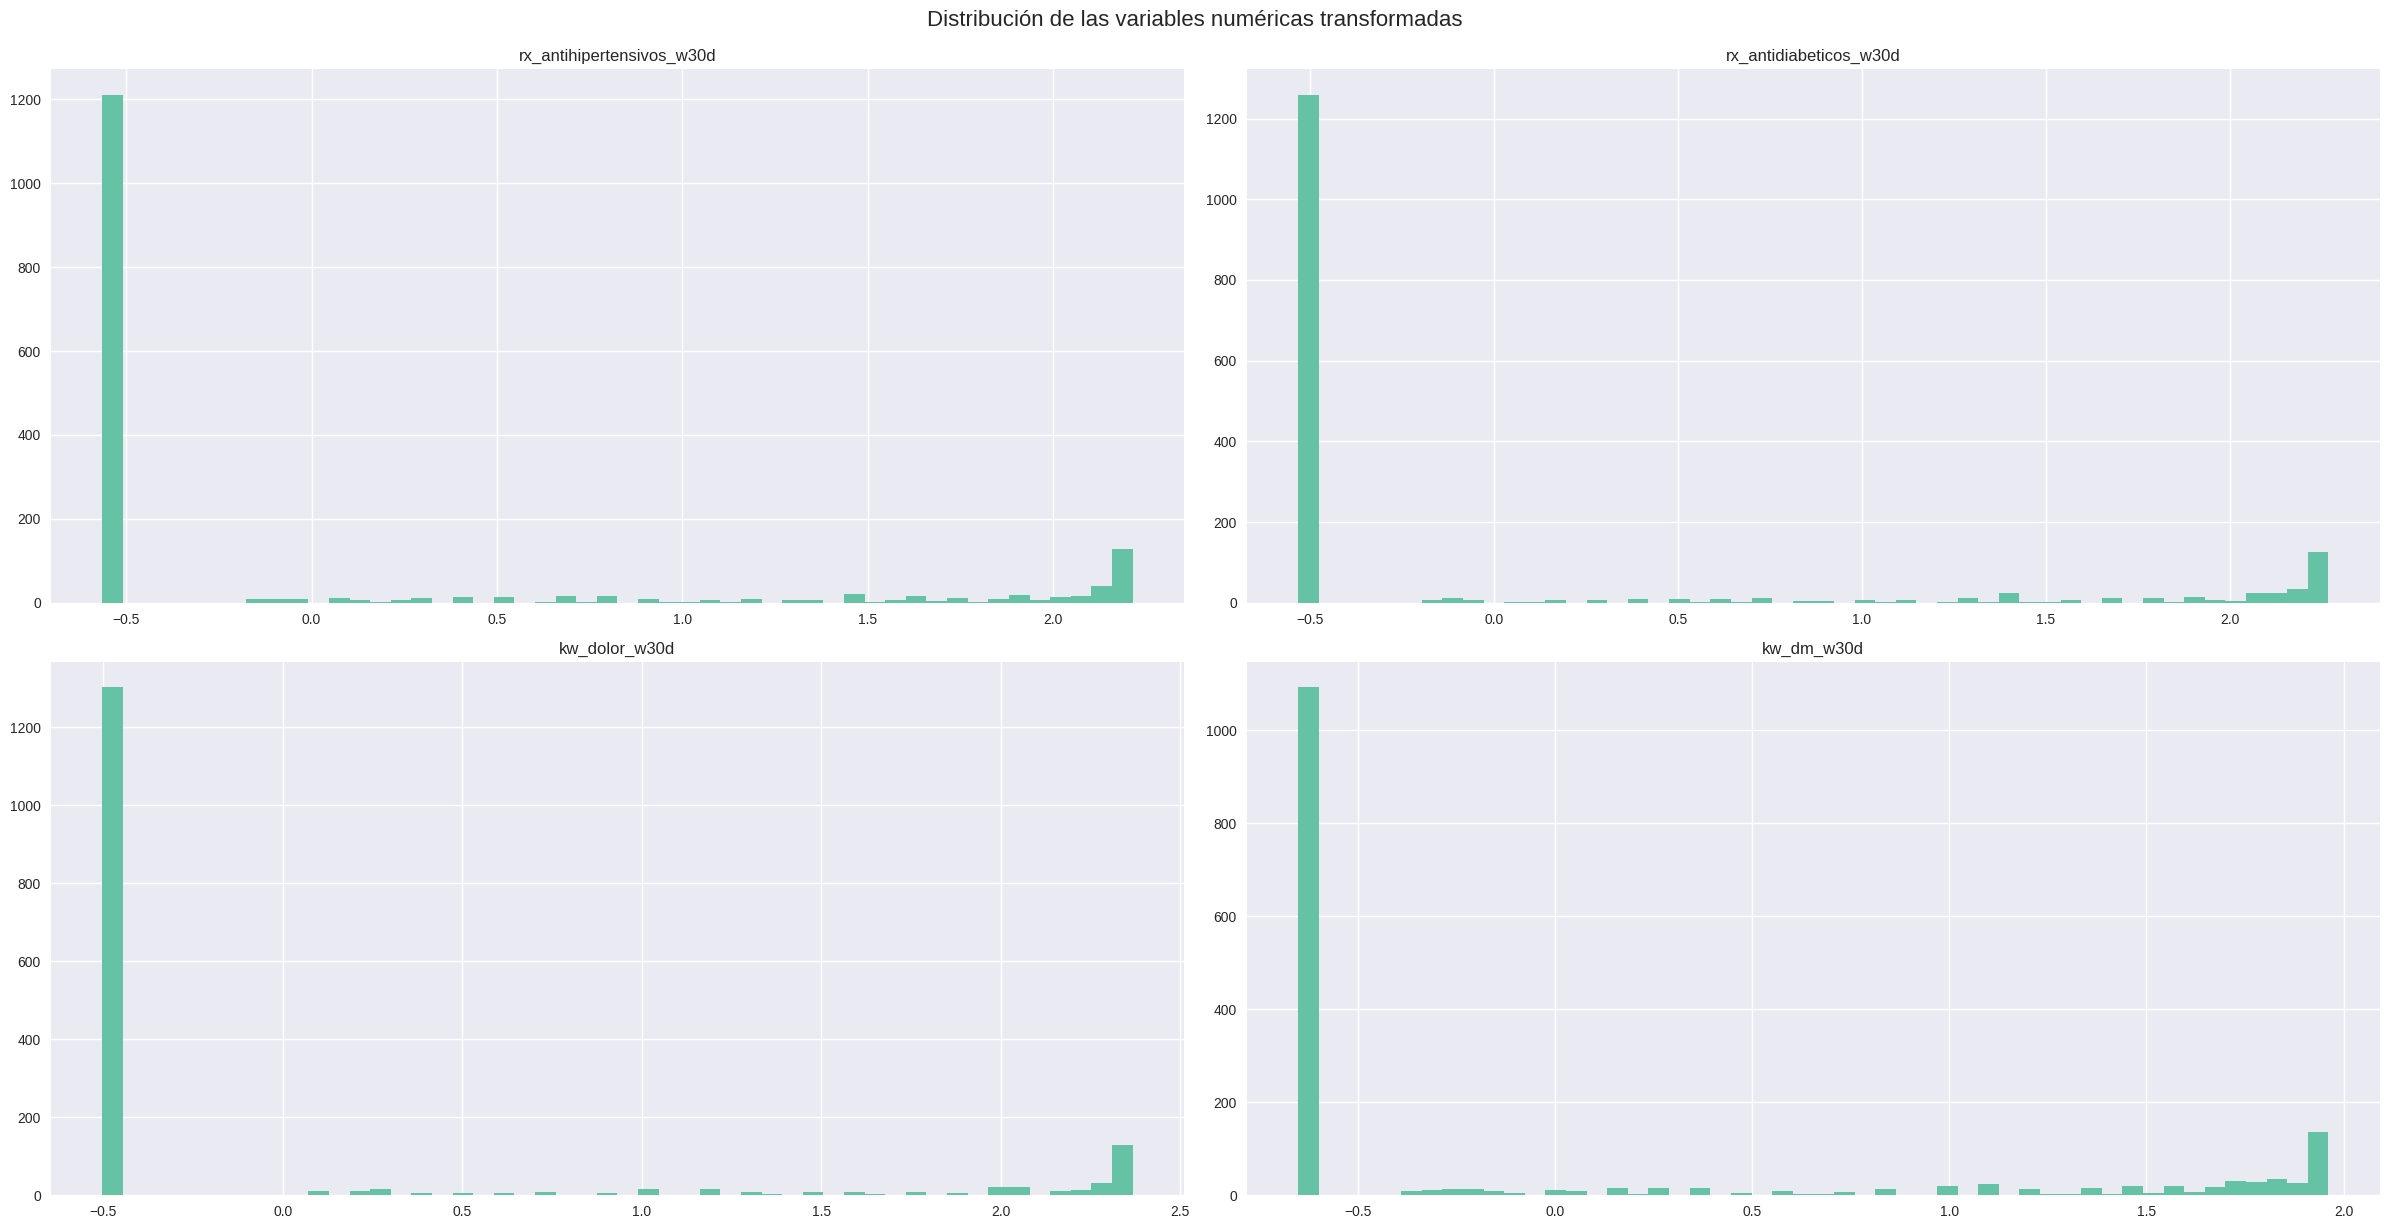

In [55]:
# Gráfico para visualizar la distribución de las variables numéricas transformadas
df_train[columnas_sesgadas].hist(bins=50, figsize=(24, 12))
plt.tight_layout()
plt.suptitle("Distribución de las variables numéricas transformadas", fontsize=16, y=1.02)
plt.show()

**4.2.3 Codificación de Categóricas**

En machine learning, los algoritmos generalmente requieren que los datos sean numéricos, por lo que las variables categóricas deben transformarse en representaciones numéricas. Existen varias técnicas de codificación:

- **Label Encoding (Codificación de etiquetas):** Asigna un número entero a cada categoría. Es simple y útil para variables ordinales, pero puede inducir un orden artificial en categorías nominales.

- **One-Hot Encoding (Codificación One-Hot):** Crea una columna binaria por cada categoría, indicando con 1 o 0 su presencia. Evita introducir un orden, pero aumenta la dimensionalidad del dataset.

- **Target Encoding (Codificación basada en la variable objetivo):** Sustituye cada categoría por una estadística de la variable objetivo (por ejemplo, la media). Puede mejorar el rendimiento, pero requiere cuidado para evitar overfitting.

La elección del método depende del tipo de variable y del modelo utilizado; algoritmos como árboles de decisión pueden manejar label encoding, mientras que regresiones lineales requieren one-hot encoding para variables nominales.


In [56]:
from sklearn.preprocessing import OneHotEncoder

# ---- 1. Identificar columnas categóricas ----
categorical_cols = df_train.select_dtypes(include='object').columns
categorical_cols = [col for col in categorical_cols if col not in target_cols + id_cols]

if len(categorical_cols) > 0:
    print(f"Columnas categóricas a codificar: {list(categorical_cols)}")

    # ---- 2. Crear y ajustar el OneHotEncoder con TRAIN ----
    onehot_encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
    onehot_encoder.fit(df_train[categorical_cols])

    # ---- 3. Función auxiliar para transformar datasets ----
    def apply_onehot(df, categorical_cols, encoder):
        onehot_encoded = encoder.transform(df[categorical_cols])
        encoded_columns = encoder.get_feature_names_out(categorical_cols)
        df_encoded = pd.DataFrame(onehot_encoded, columns=encoded_columns, index=df.index)

        # Mantener columnas no categóricas
        numeric_cols = df.drop(columns=categorical_cols).columns
        df_final = pd.concat([df[numeric_cols], df_encoded], axis=1)
        return df_final

    # ---- 4. Aplicar a train, val y test ----
    df_train_final = apply_onehot(df_train, categorical_cols, onehot_encoder)
    df_val_final   = apply_onehot(df_val, categorical_cols, onehot_encoder)
    df_test_final  = apply_onehot(df_test, categorical_cols, onehot_encoder)

    print(f"Dataset train: {df_train.shape} → {df_train_final.shape}")
    print(f"Dataset val:   {df_val.shape} → {df_val_final.shape}")
    print(f"Dataset test:  {df_test.shape} → {df_test_final.shape}")
    print(f"Se crearon {len(onehot_encoder.get_feature_names_out(categorical_cols))} nuevas columnas categóricas")

else:
    print("No se encontraron columnas categóricas para codificar")
    df_train_final, df_val_final, df_test_final = df_train.copy(), df_val.copy(), df_test.copy()


Columnas categóricas a codificar: ['GENERO', 'UBICACION']
Dataset train: (1678, 66) → (1678, 137)
Dataset val:   (475, 66) → (475, 137)
Dataset test:  (706, 66) → (706, 137)
Se crearon 73 nuevas columnas categóricas


**4.2.4 Análisis de Escalamiento**

El análisis de escalamiento se utiliza para transformar y normalizar los datos numéricos, asegurando que las características estén en una escala comparable. Esto es fundamental cuando los modelos de machine learning son sensibles a la magnitud de los valores, como regresión, redes neuronales o algoritmos basados en distancias.

Los métodos más comunes incluyen:

- **Min-Max Scaling:** Escala los valores a un rango fijo, normalmente entre 0 y 1. Conserva la forma de la distribución original, pero es sensible a valores atípicos.

- **Standardization (Estandarización):** Ajusta los datos para que tengan media 0 y desviación estándar 1. Es útil cuando se requiere que los datos tengan distribución centrada.

- **Robust Scaling:** Similar a la estandarización, pero utiliza la mediana y el rango intercuartílico, reduciendo el impacto de los outliers.

El escalamiento adecuado mejora la convergencia de los algoritmos, evita que variables con grandes magnitudes dominen el modelo y facilita la interpretación de los resultados.

Se aplica StandardScaler para normalizar las variables numéricas, de manera que cada una tenga media cero y desviación estándar uno. Esto permite que todas las variables estén en la misma escala, reduciendo la influencia de la magnitud de los valores y facilitando que los algoritmos de machine learning converjan de manera más eficiente, generando modelos más robustos.

In [57]:
from sklearn.preprocessing import StandardScaler

# ---- 1. Identificar columnas numéricas a escalar ----
numeric_cols = df_train_final.select_dtypes(include=['float64', 'int64']).columns
numeric_cols = [col for col in numeric_cols if col not in target_cols + id_cols]

# ---- 2. Crear y ajustar el StandardScaler con TRAIN ----
scaler = StandardScaler()
scaler.fit(df_train_final[numeric_cols])

# ---- 3. Transformar train, val y test ----
def scale_numeric(df, cols, scaler):
    df_scaled = df.copy()
    df_scaled[cols] = scaler.transform(df[cols])
    return df_scaled

df_train_scaled = scale_numeric(df_train_final, numeric_cols, scaler)
df_val_scaled   = scale_numeric(df_val_final, numeric_cols, scaler)
df_test_scaled  = scale_numeric(df_test_final, numeric_cols, scaler)

print(f"Columnas numéricas escaladas: {numeric_cols}")
print()
print(f"Dataset train escalado: {df_train_scaled.shape}")
print(f"Dataset val escalado:   {df_val_scaled.shape}")
print(f"Dataset test escalado:  {df_test_scaled.shape}")

Columnas numéricas escaladas: ['ACIDO_URICO', 'ALBUMINA', 'ALBUMINA_EN_SUERO', 'BILIRRUBINA_DIRECTA', 'BILIRRUBINA_INDIRECTA', 'BILIRRUBINA_TOTAL', 'CALCIO', 'COLESTEROL_HDL', 'COLESTEROL_LDL', 'COLESTEROL_TOTAL', 'COLESTEROL_VLDL', 'CREATININA_SERICA', 'DENSIDAD', 'DESHIDROGENASA_LACTICA', 'ERITROCITOS', 'FOSFATA_ALCALINA', 'FOSFORO', 'GLOBULINA', 'GLUCOSA_EN_SUERO_AYUNO', 'HEMATOCRITOS', 'HEMOGLOBINA', 'HEMOGLOBINA_GLUCOSILADA_HBA1C', 'HIERRO', 'IMC', 'INDICE_ATEROGENICO', 'LEUCOCITOS_TOTALES', 'NITROGENO_UREICO_BUN', 'OXIMETRIA_CAPILAR', 'PESO', 'PH', 'PLAQUETAS', 'POTASIO', 'PROTEINA_C_REACTIVA', 'PROTEINA_TOTAL', 'SODIO', 'TALLA', 'TENSION_ARTERIAL_SISTOLICA', 'TRIGLICERIDOS', 'TENSION_ARTERIAL_DIASTOLICA', 'DIAS_EN_PROGRAMA', 'EDAD', 'rx_w30d', 'rx_meds_unicos_30d', 'rx_consultas_30d', 'rx_polifarmacia_30d', 'rx_estatinas_w30d', 'rx_antibioticos_w30d', 'rx_antihipertensivos_w30d', 'rx_antidiabeticos_w30d', 'notas_w30d', 'tokens_notas_w30d', 'kw_adherencia_w30d', 'kw_infeccion_w30

In [60]:
# Se guardan los datasets transformados
df_train_scaled.to_csv(base_path + "df_train_transformed.csv", index=False)
df_val_scaled.to_csv(base_path  +"df_val_transformed.csv", index=False)
df_test_scaled.to_csv(base_path + "df_test_transformed.csv", index=False)

**4.2.5 Selección univariada hacia la etiqueta**

*   Numéricas: ANOVA F + Información Mutua (no paramétrica).
*   Categóricas: Chi-cuadrado (con agregación de categorías raras).

4.2.5 A) Carga + Target fijo (30d)

In [61]:
df_mastertable = pd.read_csv(base_path + "df_train_transformed.csv", low_memory=False)

TARGET_COL = "target_hosp_30d"
assert TARGET_COL in df_mastertable.columns, f"No existe '{TARGET_COL}' en el dataset."
y = df_mastertable[TARGET_COL].astype(int)
assert y.nunique() >= 2, "El target elegido tiene una sola clase."

## 4.2.5 B) Selección de target



In [63]:
candidatos = ["target_hosp_15d","target_hosp_21d","target_hosp_30d","target_hosp_90d"]
disp = []
for c in [t for t in candidatos if t in df_mastertable.columns]:
    vc = df_mastertable[c].value_counts(dropna=False)
    pos = int(vc.get(1, 0)); neg = int(vc.get(0, 0))
    prev = 100 * (pos / max(1,(pos+neg)))
    disp.append({"target": c, "positivos": pos, "negativos": neg, "prev_%": round(prev,2)})
print("Prevalencia por target:")
display(pd.DataFrame(disp).sort_values("prev_%"))

Prevalencia por target:


,target,positivos,negativos,prev_%
0,target_hosp_15d,13,1665,0.77
1,target_hosp_21d,18,1660,1.07
2,target_hosp_30d,48,1630,2.86
3,target_hosp_90d,148,1530,8.82


**Prevalencias (df_train_transformed):**
- `target_hosp_15d`: **0.77%** (13 pos / 1,665 neg)
- `target_hosp_21d`: **1.07%** (18 pos / 1,660 neg)
- `target_hosp_30d`: **2.86%** (48 pos / 1,630 neg) ← **elegido**
- `target_hosp_90d`: **8.82%** (148 pos / 1,530 neg)

**Justificación de `target_hosp_30d`:**
- **Relevancia clínica:** 30 días es un horizonte estándar para eventos agudos y seguimiento postintervención.
- **Balance señal/dificultad:** prevalencia **2.86%** plantea un reto realista de clase rara, útil para validar métodos de selección/balanceo, sin ser tan extrema como 15d/21d.
- **Tamaño de muestra:** **48 positivos** permiten entrenar modelos con selección conservadora (EPV), y evaluar estrategias de **balanceo** y **selección supervisada** (Chi²/ANOVA).
- **Evita confundir ventanas:** 90d tiene más señal (8.82%), pero mezcla dinámicas de más largo plazo; 30d mantiene foco en riesgo temprano y decisiones operativas de corto plazo.

> Nota: Para 30d, limitar el número de variables (p.ej., **K=6–12**) y usar CV estratificada + **Average Precision** como métrica clave.

**4.2.5 C Limpieza desde el ORIGEN**)

In [64]:
# -------------------------------
# C) Limpieza desde el ORIGEN
# -------------------------------
# Quita ID/fechas/códigos y cualquier target_* distinto al elegido
cols_drop_manual = ["ID_EHT", "FECHA_MES_5", "CODMES", "target_hosp_15d", "target_hosp_21d", "target_hosp_90d"]
leaks_all = [c for c in df_mastertable.columns if c.startswith("target_") and c != TARGET_COL]
cols_to_drop = sorted(set(cols_drop_manual + leaks_all))
cols_to_drop_exist = [c for c in cols_to_drop if c in df_mastertable.columns]

X = df_mastertable.drop(columns=[TARGET_COL] + cols_to_drop_exist, errors="ignore").copy()

print("[TextMark] Target y limpieza")
print(f"- Target usado: {TARGET_COL}")
print(f"- Columnas excluidas de X: {cols_to_drop_exist}")
print(f"- Shapes -> X: {X.shape} | y: {y.shape}")
print(f"- Prevalencia 30d -> pos={int((y==1).sum())}, neg={int((y==0).sum())}, prev%={100*(y.mean()):.2f}")

[TextMark] Target y limpieza
- Target usado: target_hosp_30d
- Columnas excluidas de X: ['CODMES', 'FECHA_MES_5', 'ID_EHT', 'target_hosp_15d', 'target_hosp_21d', 'target_hosp_90d']
- Shapes -> X: (1678, 130) | y: (1678,)
- Prevalencia 30d -> pos=48, neg=1630, prev%=2.86


**4.2.5 D)**  Selección mixta de características — ¿Por qué **Chi² + ANOVA**?

**Objetivo del bloque:** reducir dimensionalidad de forma **supervisada** y **explicable**, antes del modelado, respetando la naturaleza de las variables y la **clase rara** del target (`~2.86%`).

**Qué hace cada método:**
- **Chi-cuadrado (Chi²)** → mide *dependencia* con la clase en **variables no negativas** (p. ej., dummies 0/1, conteos).  
  *Requisito:* escalar a \[0,1\] con **MinMaxScaler** para cumplir el supuesto de no-negatividad.
- **ANOVA (f_classif)** → contrasta *diferencias de medias* entre clases en **variables continuas**.  
  *Requisito:* **StandardScaler** para estabilizar varianzas.

**Por qué combinarlos:**
- El dataset contiene una mezcla de **continuas** y posibles **no-negativas** (one-hots/conteos).  
  → **Chi²** captura señal en dummies/conteos; **ANOVA** captura señal en continuas.  
- Son **complementarios** y **explicables** (scores/p-values), lo que facilita justificar la selección.
- Con **pocos positivos**, conviene un **K total pequeño** (EPV): aquí fijamos `K_TOTAL=10` y lo repartimos (p. ej., `Chi²=4`, `ANOVA=6`) para limitar complejidad y riesgo de sobreajuste.

**Cómo se implementa (sin fuga):**
- Se separan columnas numéricas en **no-negativas** y **continuas**.
- Se construye un **ColumnTransformer** con dos sub-pipelines:
  - `MinMaxScaler → SelectKBest(chi2)` para no-negativas.
  - `StandardScaler → SelectKBest(f_classif)` para continuas.
- Todo vive dentro de un **Pipeline** con el clasificador (`LogisticRegression(class_weight="balanced")`) para que cada paso se **ajuste solo en train** dentro de la validación cruzada.

**Ventajas clave:**
- **Reducción de complejidad**: `K_TOTAL ≪ #features` → entrenamiento más rápido y estable.
- **Alineado al EDA**: cada tipo de variable usa la prueba adecuada.
- **Interpretabilidad**: fácil reportar “Top-K” por criterio (Chi²/ANOVA) con p-values/scores.
- **Reproducibilidad**: diseño en Pipeline + CV estratificada evita **fuga de información**.

> Nota: si en un dataset concreto no se detectan columnas **no-negativas**, el bloque Chi² queda **inactivo** (K=0) y la selección ocurre vía **ANOVA**, manteniendo el enfoque supervisado y sin romper el flujo.


In [66]:
# -------------------------------
# D) Selección mixta: Chi² + ANOVA
# -------------------------------
# Partición de columnas numéricas en no-negativas vs continuas
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
nonneg_cols = [c for c in num_cols if X[c].min() >= 0]
cont_cols   = [c for c in num_cols if c not in nonneg_cols]

print(f"Cols continuas: {len(cont_cols)} | Cols no-negativas (dummies/conteos): {len(nonneg_cols)}")

# Define K totales y reparto
K_TOTAL = 10
K_CHI2  = min(4, len(nonneg_cols))                 # parte para Chi²
K_ANOVA = min(K_TOTAL - K_CHI2, len(cont_cols))    # parte para ANOVA

# Pipelines por bloque
pipe_chi2 = Pipeline([
    ("minmax", MinMaxScaler()),                 # requerido por Chi²
    ("sel", SelectKBest(chi2, k=K_CHI2))
])
pipe_anova = Pipeline([
    ("std", StandardScaler()),
    ("sel", SelectKBest(f_classif, k=K_ANOVA))
])

pre = ColumnTransformer([
    ("chi2_block",  pipe_chi2,  nonneg_cols),
    ("anova_block", pipe_anova, cont_cols),
])

clf = LogisticRegression(max_iter=500, class_weight="balanced")

full_pipe = Pipeline([
    ("pre", pre),
    ("clf", clf)
])

Cols continuas: 130 | Cols no-negativas (dummies/conteos): 0


**4.2.5 E) Evaluación CV (AUROC/AP)**

roc_auc: 0.579
average_precision: 0.076
AUROC: 0.5783742331288344
AP: 0.04346505747628754
Umbral para recall>=0.80: nan


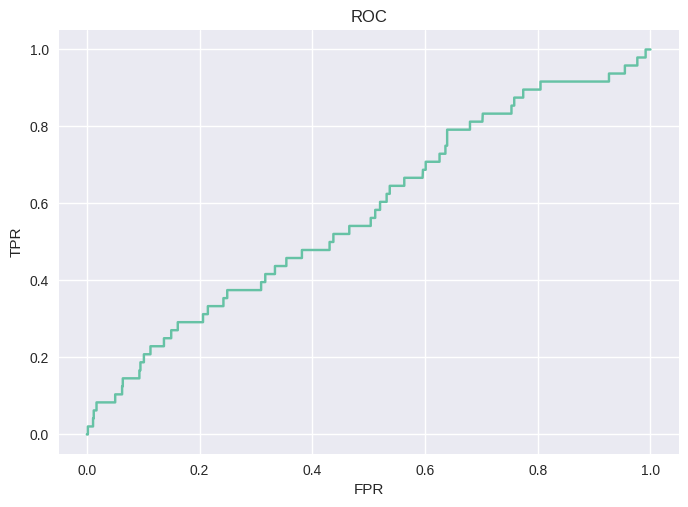

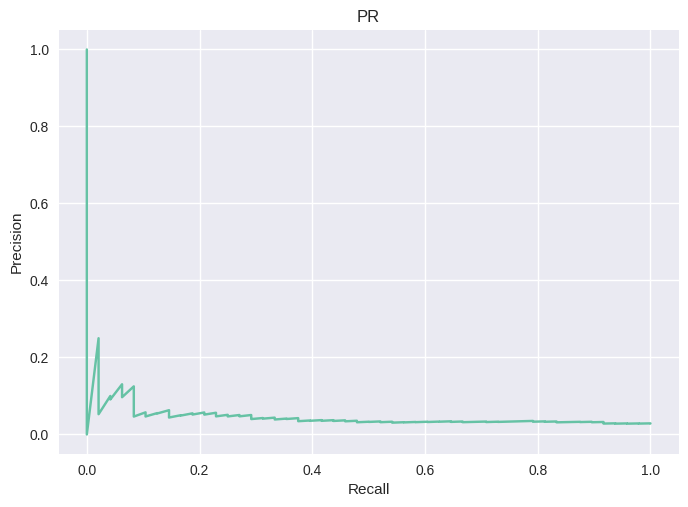

In [67]:
# -------------------------------
# E) Evaluación CV (AUROC/AP)
# -------------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for metric in ["roc_auc", "average_precision"]:
    score = cross_val_score(full_pipe, X, y, cv=cv, scoring=metric).mean()
    print(f"{metric}: {score:.3f}")

# Curvas ROC y PR + umbral de recall objetivo
y_scores, y_true = [], []
for tr, te in cv.split(X, y):
    full_pipe.fit(X.iloc[tr], y.iloc[tr])
    y_scores.append(full_pipe.predict_proba(X.iloc[te])[:,1])
    y_true.append(y.iloc[te].values)

y_scores = np.concatenate(y_scores); y_true = np.concatenate(y_true)
fpr, tpr, thr = roc_curve(y_true, y_scores)
prec, rec, thr_pr = precision_recall_curve(y_true, y_scores)

print("AUROC:", auc(fpr, tpr))
print("AP:", auc(rec, prec))

plt.figure(); plt.plot(fpr, tpr); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC");
plt.figure(); plt.plot(rec, prec); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR");

# Umbral para recall >= 0.80 (si existe punto)
idx = np.where(rec >= 0.80)[0]
thr80 = float(thr_pr[idx[0]-1]) if len(idx) > 0 and (idx[0]-1) >= 0 else np.nan
print("Umbral para recall>=0.80:", thr80)

## Evaluación con CV (AUROC / AP) y umbral operativo

**Métricas promedio (CV estratificada, out-of-fold):**
- `roc_auc` (cross_val_score): **0.579**
- `average_precision` (cross_val_score): **0.076**

**Curvas integradas (con scores out-of-fold):**
- **AUROC (curva):** 0.578
- **AP (PR-AUC, curva):** 0.043

> La **AP** de `cross_val_score` (0.076) y la **AP** integrada (0.043) pueden diferir porque:
> 1) el promedio fold-a-fold (macro) no coincide con la integración sobre todos los scores concatenados (micro),
> 2) pequeñas variaciones por la distribución de positivos en cada fold (clase rara).

**Umbral para `recall ≥ 0.80`:** `NaN`  
No se alcanza ese nivel de sensibilidad con el ranking actual sin deteriorar drásticamente la precisión.

### Lectura rápida
- **AUROC ≈ 0.58**: señal débil pero distinta de azar; hay separación limitada entre clases.
- **AP baja** (0.043–0.076) con prevalencia **2.86%**: el modelo aún no concentra suficientes positivos en la parte alta de probabilidades.

### Recomendaciones inmediatas
1. **Balanceo:** usar **UnderSampling** moderado (p. ej., pos:neg ≈ 1:2) que ya mostró mejora de **AP** en el benchmark.
2. **Selección supervisada:** mantener **K pequeño** (6–12) con ANOVA/Chi² para reducir ruido (EPV).
3. **Ingeniería de variables:** recencia/tendencias (30/60/90d), ratios clínicos (p. ej., TG/HDL), interacciones (EDAD×HTN), y one-hot limpio para activar Chi².
4. **Modelo alterno:** probar **BalancedRF/XGBoost** tras mejorar features; optimizar `scale_pos_weight`/hiperparámetros.
5. **Umbral operativo:** fijar un **recall objetivo más realista** (p. ej., 0.60–0.70) mientras se itera en features y balanceo; reportar precisión y Fβ en ese umbral.

**Conclusión:** el pipeline es correcto y reproducible (sin fuga), pero requiere **mejoras de features y balanceo** para elevar especialmente la **AP** (métrica clave en clase rara).


**4.2.5 E) Features finales (sin fuga)**

In [70]:
# -------------------------------
# F) Features finales (sin fuga)
# -------------------------------
pre_fit = full_pipe.named_steps["pre"]
chi2_sel = pre_fit.named_transformers_["chi2_block"].named_steps["sel"]
anova_sel = pre_fit.named_transformers_["anova_block"].named_steps["sel"]

nonneg_cols_sel = list(np.array(nonneg_cols)[chi2_sel.get_support()]) if K_CHI2 > 0 else []
cont_cols_sel   = list(np.array(cont_cols)[anova_sel.get_support()])  if K_ANOVA > 0 else []
selected = nonneg_cols_sel + cont_cols_sel

print("Features finales:", selected)

Features finales: [np.str_('GLUCOSA_EN_SUERO_AYUNO'), np.str_('TRIGLICERIDOS'), np.str_('DIAS_EN_PROGRAMA'), np.str_('rx_antihipertensivos_w30d'), np.str_('kw_htn_w30d'), np.str_('UBICACION_Benito Juárez'), np.str_('UBICACION_Huixquilucan'), np.str_('UBICACION_Reynosa'), np.str_('UBICACION_Texcoco'), np.str_('UBICACION_Tlalnepantla de Baz')]


**4.2.6 Análisis de Desbalance de clases**

In [71]:
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedRandomForestClassifier
from xgboost import XGBClassifier

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def cv_scores(model, X, y, name):
    auroc = cross_val_score(model, X, y, cv=cv, scoring="roc_auc").mean()
    ap    = cross_val_score(model, X, y, cv=cv, scoring="average_precision").mean()
    print(f"{name:<22} AUROC={auroc:.3f} | AP={ap:.3f}")
    return ap

# 1) Logistic Regression con class_weight (sin remuestreo)
pipe_lr_bal = Pipeline([
    ("pre", pre),
    ("clf", LogisticRegression(max_iter=800, class_weight="balanced", n_jobs=-1))
])

# 2) UnderSampling + LR (pos:neg ≈ 1:2)
pipe_under_lr = ImbPipeline([
    ("pre", pre),
    ("under", RandomUnderSampler(sampling_strategy=0.5, random_state=42)),
    ("clf", LogisticRegression(max_iter=800, n_jobs=-1))
])

# 3) Balanced Random Forest (con pre para mantener mismas features seleccionadas)
pipe_brf = Pipeline([
    ("pre", pre),
    ("clf", BalancedRandomForestClassifier(
        n_estimators=600, max_depth=None, random_state=42, n_jobs=-1
    ))
])

# 4) XGBoost con peso de clase (scale_pos_weight ≈ neg/pos)
ratio = (y==0).sum() / max(1,(y==1).sum())
pipe_xgb = Pipeline([
    ("pre", pre),
    ("clf", XGBClassifier(
        n_estimators=700, max_depth=3, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
        scale_pos_weight=ratio, random_state=42, n_jobs=-1, tree_method="hist"
    ))
])

print(">> Benchmark (foco: Average Precision)")
best_ap = -1.0; best_name = None
for model, name in [
    (pipe_lr_bal, "LR balanced"),
    (pipe_under_lr, "Under+LR (0.5)"),
    (pipe_brf,     "BalancedRF"),
    (pipe_xgb,     f"XGBoost (spw≈{ratio:.1f})"),
]:
    ap = cv_scores(model, X, y, name)
    if ap > best_ap:
        best_ap, best_name = ap, name

print(f"\nMejor por AP: {best_name} (AP={best_ap:.3f})")

>> Benchmark (foco: Average Precision)
LR balanced            AUROC=0.579 | AP=0.076
Under+LR (0.5)         AUROC=0.580 | AP=0.084
BalancedRF             AUROC=0.609 | AP=0.059
XGBoost (spw≈34.0)     AUROC=0.605 | AP=0.066

Mejor por AP: Under+LR (0.5) (AP=0.084)


## Benchmark de balanceo (foco: Average Precision)

**Configuración comparada (con el mismo preprocesador Chi²/ANOVA en Pipeline + CV estratificada):**
- **LR balanced** (`class_weight="balanced"`) → **AUROC=0.579 | AP=0.076**
- **Under+LR (0.5)** (submuestreo mayoritaria ~1:2) → **AUROC=0.580 | AP=0.084** ← **mejor AP**
- **BalancedRF** → **AUROC=0.609 | AP=0.059**
- **XGBoost (scale_pos_weight≈34)** → **AUROC=0.605 | AP=0.066**

**Lectura:**
- En una **clase rara (≈2.86%)**, la métrica prioritaria es **AP (PR-AUC)**.  
- **Under+LR (0.5)** logra la **mejor AP (0.084)**, superando a pesos de clase y a ensambles en esta configuración.  
- Aunque **RF/XGB** obtienen **AUROC** algo mayor, **no** superan a Under+LR en **AP**, indicando que **no concentran** tantos positivos en la parte alta del ranking de probabilidad.

**Implicaciones y próximos pasos:**
1. **Baseline recomendado:** adoptar **Under+LR (0.5)** como referencia actual.
2. **Afina el ratio de under-sampling:** probar `sampling_strategy ∈ {0.33, 0.5, 0.8}` y elegir por **AP**.
3. **Selección supervisada conservadora:** mantener **K** pequeño (6–12) con **ANOVA/Chi²** para reducir ruido (EPV).
4. **Umbral operativo:** trazar **Precision–Recall** y fijar umbral para **recall objetivo** (p. ej., 0.70–0.80), reportando precisión y Fβ.
5. **Ingeniería de variables:** recencia/tendencias (30/60/90d), ratios clínicos (p. ej., TG/HDL), interacciones (EDAD×HTN, TG×DIAS_EN_PROGRAMA) y dummies limpios (activar Chi² real).
6. **Reintentar ensambles tras mejoras:** tuning en **BalancedRF** (`n_estimators`, `max_depth`) y **XGBoost** (`max_depth`, `learning_rate`, `scale_pos_weight`) una vez que se fortalezcan las features.

**Conclusión:** el submuestreo moderado **Under+LR (0.5)** ofrece el mejor balance entre **simplicidad**, **AP** y **reproducibilidad** en la situación actual de desbalance y tamaño de la clase positiva.




